In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Specify the file path in Google Drive
file_path = '/content/drive/MyDrive/Diss/roberta xlnet/combined_results.csv'

# Read the CSV file into a Data
df = pd.read_csv(file_path)


In [ ]:
# referenced and modified - https://www.kaggle.com/code/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [3]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install nltk

In [3]:
# import relevant packages
import os
from collections import Counter

import tensorflow as tf
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.utils import to_categorical, pad_sequences
from keras.layers import Embedding

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import nltk
import re

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [4]:
pd.set_option('display.max_colwidth', None)
tf.keras.backend.set_image_data_format("channels_last")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Loading English stop words
stop = nltk.corpus.stopwords.words('english')

In [7]:
def pre_process_text_data(text: str) -> str:
    # normalize and remove special characters
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]+',' ',text)
    # remove stop words
    words = text.split()
    words = [w for w in words if (w not in stop)]
    words = ' '.join(words)
    return words

In [8]:
df['Summary'] = df['Summary'].apply(pre_process_text_data)


In [9]:
from sklearn.preprocessing import LabelEncoder

# Example emotion labels
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Create a LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the emotion labels
encoded_labels = label_encoder.fit_transform(emotion_labels)

# Print the mapping between original labels and encoded labels
label_mapping = dict(zip(emotion_labels, encoded_labels))
print(label_mapping)


{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame and 'Summary_Emotion' is the column with string labels
label_encoder = LabelEncoder()

# Fit and transform the 'Summary_Emotion' column and replace it
df['encoded_emotion'] = label_encoder.fit_transform(df['Summary_Emotion'])


In [11]:
df.head(1)

,Publication Date,Source,URL,Title,Summary,Categories,Industries,Organisations,People,Locations,Other Entities,News topic,Title_Emotion,Title_Emotion_Score,Summary_Emotion,Summary_Emotion_Score,encoded_emotion
0,2023-10-07T03:11:36+0000,Yahoo,https://news.yahoo.com/gov-renews-public-health-order-030100117.html,"Gov. renews public health order, tacks on gun buy-backs, substance abuse treatment",oct 6 gov michelle lujan grisham friday renewed public health order aimed combating gun violence added new provisions state organize gun buy backs albuquerque espa ola las cruces provide treatment seeking help battling addictions order also includes several initial measures including testing wastewater schools drugs like fentanyl monthly inspections licensed gun dealers violations allowing police book juveniles jail without social services permission sending new mexico state police officers help local authorities fight crime albuquerque bernalillo county deputies officers arrested hundreds people following order unclear effect gun violence initiatives testing school wastewater stand friday new items added order including gun buy backs state health care system would ensure request help substance abuse receive permanent adequate treatment placement within 24 hours request renewal comes month governor declared gun violence public health emergency following high profile shooting death 11 year old boy initially enforced short lived ban publicly carrying firearms bernalillo county lujan grisham amended portion order ban carrying guns public parks playgrounds across bernalillo county something city albuquerque already sought challenged court,Non-Standard Content\nExtreme Graphic/Explicit Violence\nHealth & Fitness\nSubstance Abuse\npolitics\ninterior policy\npersonal weapon control\nHealth and Wellness\nHealth Sciences\nPublic Health\nLife and Society\nSocial Issues\nViolence\nMedical Disorders and Diseases\nSubstance Abuse\nAddiction and Drug Abuse,NaN,"Albuquerque, New Mexico",NaN,"Albuquerque, New Mexico",Michelle Lujan Grisham,Albuquerque gun ban,neutral,0.728747,neutral,0.410288,4


In [12]:
counts = Counter()
for i, review in enumerate(df['Summary']):
    counts.update(review.split())

In [13]:
words = sorted(counts, key=counts.get, reverse=True)
words[0:10]

['said',
 'trump',
 'de',
 'new',
 'president',
 'news',
 '2023',
 'former',
 'police',
 'year']

In [14]:
word_to_int = {word: i for i, word in enumerate(words, start=1)}
int_to_word = {i: word for i, word in enumerate(words, start=1)}

In [15]:
def text_to_int(text:str, word_to_int: dict):
    return [word_to_int[word] for word in review.split()]


def int_to_text(int_arr, int_to_word: dict):
    return ' '.join([int_to_word[index] for index in int_arr if index != 0])

In [16]:
mapped_news = []
for news in df['Summary']:
    mapped_news.append(text_to_int(news, word_to_int))

In [17]:
print(f'Original news: {df.loc[0]["Summary"]}')
print(f'Mapped news: {mapped_news[0]}')

Original news: oct 6 gov michelle lujan grisham friday renewed public health order aimed combating gun violence added new provisions state organize gun buy backs albuquerque espa ola las cruces provide treatment seeking help battling addictions order also includes several initial measures including testing wastewater schools drugs like fentanyl monthly inspections licensed gun dealers violations allowing police book juveniles jail without social services permission sending new mexico state police officers help local authorities fight crime albuquerque bernalillo county deputies officers arrested hundreds people following order unclear effect gun violence initiatives testing school wastewater stand friday new items added order including gun buy backs state health care system would ensure request help substance abuse receive permanent adequate treatment placement within 24 hours request renewal comes month governor declared gun violence public health emergency following high profile shoo

In [18]:
length_sent = []
for i in range(len(mapped_news)):
    length_sent.append(len(mapped_news[i]))

In [19]:
sequence_length = max(length_sent)
X = pad_sequences(maxlen = sequence_length,
                  sequences = mapped_news,
                  padding = "post",
                  value = 0)

In [20]:
X[0]

array([16379,   517, 13754,   669, 30206, 22967,  4103,    24,  3829,
           9, 11372, 37440,   121,  1092,  1990,   553,  1010,  8757,
          18, 34663,    91,    16,  1751,   402,  5836,   909,  4956,
        9221,   653,  3402,  1446,  3684,    91,  1201, 11372,   975,
           1,  3050,  1591, 30311, 23002, 13370,   706, 37439, 30311,
       37440, 11372,  9620, 46022,     6,   591,    88,  3684,     1,
       40139,  5553,   853, 13055, 52589,  5803, 13520, 46030, 10589,
         520, 23002, 46068,  5875,   669,  3050,  1009,     9,   690,
         721,    91,   205,   531,  9047,   684,  1781,   447,   207,
        1781,   517,   669,  1009], dtype=int32)

In [21]:
y = df['encoded_emotion'].values

In [22]:
# Assuming 'df' is your DataFrame
grouped_by_topic = df.groupby('News topic')
topic_dfs = {topic: group for topic, group in grouped_by_topic}


In [23]:
embedding_vector_length = 100
max_news_length = 85  # Update to your intended maximum sequence length


In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming 'df' is your DataFrame with 'Summary', 'News_Topic', and 'Sentiment' columns
# Extract the 'summary', 'news_topic', and 'sentiment' columns
summaries = df['Summary'].astype(str)
news_topics = df['News topic']
sentiments = df['Summary_Emotion']

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summaries)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index

# Directory to save the models
save_directory = '/content/drive/MyDrive/Diss/many to one lstm/separated h5/'

# Iterate over each unique news topic
for topic in df['News topic'].unique():
    # Filter the DataFrame for the current topic
    topic_df = df[df['News topic'] == topic]

    # Extract 'summary' and 'sentiment' columns for the current topic
    topic_summaries = topic_df['Summary'].astype(str)
    topic_sentiments = topic_df['Summary_Emotion']

    # Tokenize the text
    sequences = tokenizer.texts_to_sequences(topic_summaries)
    padded_sequences = pad_sequences(sequences, maxlen=max_news_length)

    # Get the number of unique emotions for the current topic
    num_classes = len(topic_sentiments.unique())

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(topic_sentiments)
    y_one_hot = to_categorical(encoded_labels, num_classes=num_classes)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, y_one_hot, test_size=0.1, random_state=42
    )

    # Build and compile the LSTM model for the current topic
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=max_news_length))
    model.add(LSTM(40, return_sequences=True))
    model.add(LSTM(40, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))  # Adjust to the correct number of classes
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16, batch_size=32)

    # Save or store the trained model for the current topic
    model.save(f"{save_directory}lstm_model_{topic}.h5")


Epoch 1/16
15/15 [==============================] - 8s 236ms/step - loss: 1.8732 - accuracy: 0.3400 - val_loss: 1.5532 - val_accuracy: 0.4200
Epoch 2/16
15/15 [==============================] - 3s 170ms/step - loss: 1.4218 - accuracy: 0.3578 - val_loss: 1.2159 - val_accuracy: 0.3000
Epoch 3/16
15/15 [==============================] - 3s 187ms/step - loss: 1.3147 - accuracy: 0.4067 - val_loss: 1.1769 - val_accuracy: 0.3400
Epoch 4/16
15/15 [==============================] - 3s 175ms/step - loss: 1.1567 - accuracy: 0.5067 - val_loss: 1.0811 - val_accuracy: 0.5600
Epoch 5/16
15/15 [==============================] - 3s 181ms/step - loss: 0.9661 - accuracy: 0.6067 - val_loss: 1.1144 - val_accuracy: 0.5400
Epoch 6/16
15/15 [==============================] - 3s 170ms/step - loss: 0.8393 - accuracy: 0.6356 - val_loss: 1.1256 - val_accuracy: 0.5600
Epoch 7/16
15/15 [==============================] - 3s 176ms/step - loss: 0.7515 - accuracy: 0.6533 - val_loss: 1.1098 - val_accuracy: 0.5400
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 213ms/step - loss: 1.5941 - accuracy: 0.5078 - val_loss: 1.2063 - val_accuracy: 0.5300
Epoch 2/16
29/29 [==============================] - 5s 183ms/step - loss: 1.1322 - accuracy: 0.5433 - val_loss: 1.0873 - val_accuracy: 0.5300
Epoch 3/16
29/29 [==============================] - 5s 177ms/step - loss: 0.9225 - accuracy: 0.6556 - val_loss: 1.1414 - val_accuracy: 0.4800
Epoch 4/16
29/29 [==============================] - 5s 177ms/step - loss: 0.6149 - accuracy: 0.8011 - val_loss: 1.3288 - val_accuracy: 0.5400
Epoch 5/16
29/29 [==============================] - 5s 184ms/step - loss: 0.5119 - accuracy: 0.8311 - val_loss: 1.3611 - val_accuracy: 0.5700
Epoch 6/16
29/29 [==============================] - 5s 179ms/step - loss: 0.3618 - accuracy: 0.8889 - val_loss: 1.6031 - val_accuracy: 0.4400
Epoch 7/16
29/29 [==============================] - 5s 183ms/step - loss: 0.2681 - accuracy: 0.9211 - val_loss: 1.7236 - val_accuracy: 0.5200
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
2/2 [==============================] - 5s 1s/step - loss: 1.7904 - accuracy: 0.1667 - val_loss: 1.7817 - val_accuracy: 0.5000
Epoch 2/16
2/2 [==============================] - 0s 222ms/step - loss: 1.7712 - accuracy: 0.4630 - val_loss: 1.7688 - val_accuracy: 0.5000
Epoch 3/16
2/2 [==============================] - 0s 223ms/step - loss: 1.7483 - accuracy: 0.4444 - val_loss: 1.7521 - val_accuracy: 0.3333
Epoch 4/16
2/2 [==============================] - 0s 231ms/step - loss: 1.7184 - accuracy: 0.4259 - val_loss: 1.7283 - val_accuracy: 0.3333
Epoch 5/16
2/2 [==============================] - 0s 213ms/step - loss: 1.6767 - accuracy: 0.4074 - val_loss: 1.6914 - val_accuracy: 0.3333
Epoch 6/16
2/2 [==============================] - 0s 248ms/step - loss: 1.6042 - accuracy: 0.4074 - val_loss: 1.6357 - val_accuracy: 0.3333
Epoch 7/16
2/2 [==============================] - 0s 240ms/step - loss: 1.5161 - accuracy: 0.3889 - val_loss: 1.5548 - val_accuracy: 0.3333
Epoch 8/16
2/2 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
4/4 [==============================] - 6s 485ms/step - loss: 1.7731 - accuracy: 0.4959 - val_loss: 1.7233 - val_accuracy: 0.7143
Epoch 2/16
4/4 [==============================] - 1s 198ms/step - loss: 1.6878 - accuracy: 0.6098 - val_loss: 1.5754 - val_accuracy: 0.7143
Epoch 3/16
4/4 [==============================] - 1s 192ms/step - loss: 1.5138 - accuracy: 0.6098 - val_loss: 1.2214 - val_accuracy: 0.7143
Epoch 4/16
4/4 [==============================] - 1s 189ms/step - loss: 1.2629 - accuracy: 0.6098 - val_loss: 1.0350 - val_accuracy: 0.7143
Epoch 5/16
4/4 [==============================] - 1s 199ms/step - loss: 1.2280 - accuracy: 0.6098 - val_loss: 0.9786 - val_accuracy: 0.7143
Epoch 6/16
4/4 [==============================] - 1s 199ms/step - loss: 1.1148 - accuracy: 0.6098 - val_loss: 0.9702 - val_accuracy: 0.7143
Epoch 7/16
4/4 [==============================] - 1s 193ms/step - loss: 1.0635 - accuracy: 0.6098 - val_loss: 0.9452 - val_accuracy: 0.7143
Epoch 8/16
4/4 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
21/21 [==============================] - 8s 216ms/step - loss: 1.6973 - accuracy: 0.5100 - val_loss: 1.5037 - val_accuracy: 0.4444
Epoch 2/16
21/21 [==============================] - 4s 176ms/step - loss: 1.1582 - accuracy: 0.6043 - val_loss: 1.2471 - val_accuracy: 0.5000
Epoch 3/16
21/21 [==============================] - 4s 177ms/step - loss: 0.9580 - accuracy: 0.6321 - val_loss: 1.2038 - val_accuracy: 0.5139
Epoch 4/16
21/21 [==============================] - 4s 178ms/step - loss: 0.7933 - accuracy: 0.6801 - val_loss: 1.1228 - val_accuracy: 0.6250
Epoch 5/16
21/21 [==============================] - 4s 171ms/step - loss: 0.6041 - accuracy: 0.7944 - val_loss: 1.1320 - val_accuracy: 0.6528
Epoch 6/16
21/21 [==============================] - 4s 172ms/step - loss: 0.4508 - accuracy: 0.8887 - val_loss: 1.2719 - val_accuracy: 0.5833
Epoch 7/16
21/21 [==============================] - 4s 180ms/step - loss: 0.3615 - accuracy: 0.9042 - val_loss: 1.3239 - val_accuracy: 0.6111
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 207ms/step - loss: 1.7319 - accuracy: 0.3567 - val_loss: 1.5063 - val_accuracy: 0.4800
Epoch 2/16
29/29 [==============================] - 5s 173ms/step - loss: 1.4610 - accuracy: 0.3878 - val_loss: 1.4149 - val_accuracy: 0.5400
Epoch 3/16
29/29 [==============================] - 5s 182ms/step - loss: 1.2505 - accuracy: 0.4822 - val_loss: 1.3237 - val_accuracy: 0.5100
Epoch 4/16
29/29 [==============================] - 5s 184ms/step - loss: 1.0362 - accuracy: 0.6244 - val_loss: 1.3348 - val_accuracy: 0.4600
Epoch 5/16
29/29 [==============================] - 5s 179ms/step - loss: 0.7474 - accuracy: 0.7267 - val_loss: 1.2221 - val_accuracy: 0.5700
Epoch 6/16
29/29 [==============================] - 5s 186ms/step - loss: 0.5883 - accuracy: 0.8089 - val_loss: 1.3147 - val_accuracy: 0.5900
Epoch 7/16
29/29 [==============================] - 5s 173ms/step - loss: 0.4693 - accuracy: 0.8389 - val_loss: 1.6076 - val_accuracy: 0.4800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
11/11 [==============================] - 8s 263ms/step - loss: 1.7546 - accuracy: 0.3171 - val_loss: 1.6898 - val_accuracy: 0.1892
Epoch 2/16
11/11 [==============================] - 2s 173ms/step - loss: 1.5082 - accuracy: 0.3201 - val_loss: 1.5285 - val_accuracy: 0.1892
Epoch 3/16
11/11 [==============================] - 2s 195ms/step - loss: 1.3591 - accuracy: 0.3384 - val_loss: 1.5005 - val_accuracy: 0.2432
Epoch 4/16
11/11 [==============================] - 2s 185ms/step - loss: 1.3292 - accuracy: 0.3079 - val_loss: 1.5071 - val_accuracy: 0.2162
Epoch 5/16
11/11 [==============================] - 2s 182ms/step - loss: 1.2365 - accuracy: 0.4665 - val_loss: 1.5003 - val_accuracy: 0.2703
Epoch 6/16
11/11 [==============================] - 2s 176ms/step - loss: 1.0791 - accuracy: 0.5945 - val_loss: 1.5040 - val_accuracy: 0.3784
Epoch 7/16
11/11 [==============================] - 2s 193ms/step - loss: 0.8887 - accuracy: 0.7195 - val_loss: 1.4156 - val_accuracy: 0.4595
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
2/2 [==============================] - 5s 1s/step - loss: 1.6081 - accuracy: 0.3043 - val_loss: 1.5818 - val_accuracy: 0.8333
Epoch 2/16
2/2 [==============================] - 0s 216ms/step - loss: 1.5835 - accuracy: 0.4783 - val_loss: 1.5488 - val_accuracy: 0.8333
Epoch 3/16
2/2 [==============================] - 0s 201ms/step - loss: 1.5540 - accuracy: 0.4565 - val_loss: 1.4983 - val_accuracy: 0.8333
Epoch 4/16
2/2 [==============================] - 0s 248ms/step - loss: 1.5081 - accuracy: 0.4565 - val_loss: 1.4185 - val_accuracy: 0.8333
Epoch 5/16
2/2 [==============================] - 0s 236ms/step - loss: 1.4386 - accuracy: 0.4565 - val_loss: 1.2853 - val_accuracy: 0.8333
Epoch 6/16
2/2 [==============================] - 0s 221ms/step - loss: 1.3349 - accuracy: 0.4565 - val_loss: 1.0782 - val_accuracy: 0.8333
Epoch 7/16
2/2 [==============================] - 0s 222ms/step - loss: 1.2137 - accuracy: 0.4565 - val_loss: 0.8754 - val_accuracy: 0.8333
Epoch 8/16
2/2 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 202ms/step - loss: 1.5978 - accuracy: 0.4844 - val_loss: 1.2810 - val_accuracy: 0.5700
Epoch 2/16
29/29 [==============================] - 5s 182ms/step - loss: 1.2603 - accuracy: 0.5156 - val_loss: 1.2036 - val_accuracy: 0.5700
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.0283 - accuracy: 0.5867 - val_loss: 1.1388 - val_accuracy: 0.5800
Epoch 4/16
29/29 [==============================] - 5s 172ms/step - loss: 0.7470 - accuracy: 0.7500 - val_loss: 1.0233 - val_accuracy: 0.6500
Epoch 5/16
29/29 [==============================] - 5s 181ms/step - loss: 0.5656 - accuracy: 0.8089 - val_loss: 1.2022 - val_accuracy: 0.6000
Epoch 6/16
29/29 [==============================] - 5s 175ms/step - loss: 0.3933 - accuracy: 0.8811 - val_loss: 1.3040 - val_accuracy: 0.5900
Epoch 7/16
29/29 [==============================] - 5s 176ms/step - loss: 0.3192 - accuracy: 0.9022 - val_loss: 1.5649 - val_accuracy: 0.6300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
23/23 [==============================] - 9s 221ms/step - loss: 1.4953 - accuracy: 0.5554 - val_loss: 1.2688 - val_accuracy: 0.4625
Epoch 2/16
23/23 [==============================] - 4s 186ms/step - loss: 1.0284 - accuracy: 0.5849 - val_loss: 1.2154 - val_accuracy: 0.4625
Epoch 3/16
23/23 [==============================] - 4s 184ms/step - loss: 0.8749 - accuracy: 0.6353 - val_loss: 1.0746 - val_accuracy: 0.5500
Epoch 4/16
23/23 [==============================] - 4s 179ms/step - loss: 0.6635 - accuracy: 0.7518 - val_loss: 1.4096 - val_accuracy: 0.5250
Epoch 5/16
23/23 [==============================] - 4s 183ms/step - loss: 0.5107 - accuracy: 0.8093 - val_loss: 1.2356 - val_accuracy: 0.5625
Epoch 6/16
23/23 [==============================] - 4s 186ms/step - loss: 0.3946 - accuracy: 0.8457 - val_loss: 1.2526 - val_accuracy: 0.5375
Epoch 7/16
23/23 [==============================] - 4s 184ms/step - loss: 0.3344 - accuracy: 0.9088 - val_loss: 1.5786 - val_accuracy: 0.5750
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
3/3 [==============================] - 5s 609ms/step - loss: 1.7860 - accuracy: 0.2135 - val_loss: 1.7661 - val_accuracy: 0.6000
Epoch 2/16
3/3 [==============================] - 1s 183ms/step - loss: 1.7534 - accuracy: 0.5169 - val_loss: 1.7245 - val_accuracy: 0.6000
Epoch 3/16
3/3 [==============================] - 1s 193ms/step - loss: 1.7027 - accuracy: 0.4270 - val_loss: 1.6564 - val_accuracy: 0.5000
Epoch 4/16
3/3 [==============================] - 1s 200ms/step - loss: 1.6248 - accuracy: 0.4157 - val_loss: 1.5328 - val_accuracy: 0.5000
Epoch 5/16
3/3 [==============================] - 1s 194ms/step - loss: 1.4825 - accuracy: 0.4157 - val_loss: 1.3214 - val_accuracy: 0.5000
Epoch 6/16
3/3 [==============================] - 1s 208ms/step - loss: 1.3271 - accuracy: 0.4157 - val_loss: 1.1604 - val_accuracy: 0.5000
Epoch 7/16
3/3 [==============================] - 1s 196ms/step - loss: 1.2643 - accuracy: 0.4157 - val_loss: 1.1134 - val_accuracy: 0.5000
Epoch 8/16
3/3 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 218ms/step - loss: 1.7253 - accuracy: 0.4233 - val_loss: 1.5401 - val_accuracy: 0.4400
Epoch 2/16
29/29 [==============================] - 5s 175ms/step - loss: 1.4747 - accuracy: 0.4311 - val_loss: 1.4895 - val_accuracy: 0.4700
Epoch 3/16
29/29 [==============================] - 5s 184ms/step - loss: 1.2011 - accuracy: 0.5500 - val_loss: 1.5500 - val_accuracy: 0.4800
Epoch 4/16
29/29 [==============================] - 5s 179ms/step - loss: 0.8703 - accuracy: 0.6556 - val_loss: 1.6962 - val_accuracy: 0.3500
Epoch 5/16
29/29 [==============================] - 5s 187ms/step - loss: 0.5485 - accuracy: 0.8656 - val_loss: 1.8097 - val_accuracy: 0.3700
Epoch 6/16
29/29 [==============================] - 5s 184ms/step - loss: 0.3002 - accuracy: 0.9244 - val_loss: 2.3212 - val_accuracy: 0.3400
Epoch 7/16
29/29 [==============================] - 5s 180ms/step - loss: 0.2150 - accuracy: 0.9400 - val_loss: 2.3331 - val_accuracy: 0.3800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
18/18 [==============================] - 8s 226ms/step - loss: 1.8645 - accuracy: 0.3002 - val_loss: 1.6353 - val_accuracy: 0.3175
Epoch 2/16
18/18 [==============================] - 4s 198ms/step - loss: 1.5657 - accuracy: 0.3535 - val_loss: 1.5416 - val_accuracy: 0.5238
Epoch 3/16
18/18 [==============================] - 3s 182ms/step - loss: 1.3305 - accuracy: 0.5364 - val_loss: 1.2249 - val_accuracy: 0.5556
Epoch 4/16
18/18 [==============================] - 3s 178ms/step - loss: 0.9112 - accuracy: 0.6607 - val_loss: 1.3016 - val_accuracy: 0.5397
Epoch 5/16
18/18 [==============================] - 3s 178ms/step - loss: 0.6601 - accuracy: 0.7922 - val_loss: 1.3944 - val_accuracy: 0.5873
Epoch 6/16
18/18 [==============================] - 3s 184ms/step - loss: 0.4674 - accuracy: 0.8792 - val_loss: 1.7511 - val_accuracy: 0.4603
Epoch 7/16
18/18 [==============================] - 3s 181ms/step - loss: 0.4410 - accuracy: 0.8810 - val_loss: 1.5702 - val_accuracy: 0.4921
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 214ms/step - loss: 1.6424 - accuracy: 0.5778 - val_loss: 1.2782 - val_accuracy: 0.6200
Epoch 2/16
29/29 [==============================] - 5s 175ms/step - loss: 1.1780 - accuracy: 0.6000 - val_loss: 1.1685 - val_accuracy: 0.6200
Epoch 3/16
29/29 [==============================] - 5s 187ms/step - loss: 0.8622 - accuracy: 0.6878 - val_loss: 1.2466 - val_accuracy: 0.6100
Epoch 4/16
29/29 [==============================] - 5s 183ms/step - loss: 0.6970 - accuracy: 0.7567 - val_loss: 1.3318 - val_accuracy: 0.5500
Epoch 5/16
29/29 [==============================] - 5s 175ms/step - loss: 0.5364 - accuracy: 0.7744 - val_loss: 1.4522 - val_accuracy: 0.4900
Epoch 6/16
29/29 [==============================] - 6s 190ms/step - loss: 0.3666 - accuracy: 0.8611 - val_loss: 1.5344 - val_accuracy: 0.5800
Epoch 7/16
29/29 [==============================] - 5s 171ms/step - loss: 0.2911 - accuracy: 0.8911 - val_loss: 1.7690 - val_accuracy: 0.4400
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 12s 237ms/step - loss: 1.7541 - accuracy: 0.3589 - val_loss: 1.5133 - val_accuracy: 0.4000
Epoch 2/16
29/29 [==============================] - 5s 184ms/step - loss: 1.5223 - accuracy: 0.3533 - val_loss: 1.4725 - val_accuracy: 0.4200
Epoch 3/16
29/29 [==============================] - 6s 199ms/step - loss: 1.2053 - accuracy: 0.5200 - val_loss: 1.4219 - val_accuracy: 0.4900
Epoch 4/16
29/29 [==============================] - 5s 182ms/step - loss: 0.7201 - accuracy: 0.7378 - val_loss: 1.6243 - val_accuracy: 0.4600
Epoch 5/16
29/29 [==============================] - 5s 174ms/step - loss: 0.4326 - accuracy: 0.8822 - val_loss: 2.1466 - val_accuracy: 0.4200
Epoch 6/16
29/29 [==============================] - 5s 174ms/step - loss: 0.3083 - accuracy: 0.9233 - val_loss: 2.1243 - val_accuracy: 0.4600
Epoch 7/16
29/29 [==============================] - 5s 184ms/step - loss: 0.2099 - accuracy: 0.9444 - val_loss: 2.2056 - val_accuracy: 0.4800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 218ms/step - loss: 1.6950 - accuracy: 0.3144 - val_loss: 1.4969 - val_accuracy: 0.3800
Epoch 2/16
29/29 [==============================] - 5s 188ms/step - loss: 1.4385 - accuracy: 0.3511 - val_loss: 1.4910 - val_accuracy: 0.2700
Epoch 3/16
29/29 [==============================] - 5s 174ms/step - loss: 1.3777 - accuracy: 0.3622 - val_loss: 1.4199 - val_accuracy: 0.2900
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 1.1637 - accuracy: 0.5333 - val_loss: 1.3982 - val_accuracy: 0.4400
Epoch 5/16
29/29 [==============================] - 5s 181ms/step - loss: 0.8692 - accuracy: 0.7022 - val_loss: 1.3808 - val_accuracy: 0.4400
Epoch 6/16
29/29 [==============================] - 5s 178ms/step - loss: 0.6640 - accuracy: 0.7789 - val_loss: 1.4196 - val_accuracy: 0.4900
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.5093 - accuracy: 0.8422 - val_loss: 1.4937 - val_accuracy: 0.4900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
1/1 [==============================] - 5s 5s/step - loss: 1.3850 - accuracy: 0.3333 - val_loss: 1.3965 - val_accuracy: 0.0000e+00
Epoch 2/16
1/1 [==============================] - 0s 238ms/step - loss: 1.3743 - accuracy: 0.5556 - val_loss: 1.4070 - val_accuracy: 0.0000e+00
Epoch 3/16
1/1 [==============================] - 0s 217ms/step - loss: 1.3629 - accuracy: 0.4444 - val_loss: 1.4187 - val_accuracy: 0.0000e+00
Epoch 4/16
1/1 [==============================] - 0s 212ms/step - loss: 1.3500 - accuracy: 0.4444 - val_loss: 1.4322 - val_accuracy: 0.0000e+00
Epoch 5/16
1/1 [==============================] - 0s 217ms/step - loss: 1.3349 - accuracy: 0.4444 - val_loss: 1.4478 - val_accuracy: 0.0000e+00
Epoch 6/16
1/1 [==============================] - 0s 226ms/step - loss: 1.3169 - accuracy: 0.4444 - val_loss: 1.4663 - val_accuracy: 0.0000e+00
Epoch 7/16
1/1 [==============================] - 0s 226ms/step - loss: 1.2951 - accuracy: 0.4444 - val_loss: 1.4886 - val_accuracy: 0.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/16
1/1 [==============================] - 0s 240ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/16
1/1 [==============================] - 0s 216ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/16
1/1 [==============================] - 0s 209ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/16
1/1 [==============================] - 0s 205ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/16
1/1 [==============================] - 0s 207ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/16
1/1 [==============================] - 0s 207ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
15/15 [==============================] - 7s 235ms/step - loss: 1.8332 - accuracy: 0.4947 - val_loss: 1.5060 - val_accuracy: 0.5283
Epoch 2/16
15/15 [==============================] - 3s 180ms/step - loss: 1.4392 - accuracy: 0.5180 - val_loss: 1.3848 - val_accuracy: 0.5283
Epoch 3/16
15/15 [==============================] - 3s 181ms/step - loss: 1.3615 - accuracy: 0.5180 - val_loss: 1.3477 - val_accuracy: 0.5283
Epoch 4/16
15/15 [==============================] - 3s 188ms/step - loss: 1.2385 - accuracy: 0.5518 - val_loss: 1.2808 - val_accuracy: 0.5660
Epoch 5/16
15/15 [==============================] - 3s 178ms/step - loss: 1.0508 - accuracy: 0.6258 - val_loss: 1.3186 - val_accuracy: 0.6038
Epoch 6/16
15/15 [==============================] - 3s 180ms/step - loss: 0.8596 - accuracy: 0.6892 - val_loss: 1.3817 - val_accuracy: 0.4528
Epoch 7/16
15/15 [==============================] - 3s 175ms/step - loss: 0.7418 - accuracy: 0.7696 - val_loss: 1.3833 - val_accuracy: 0.5283
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 212ms/step - loss: 1.7028 - accuracy: 0.3233 - val_loss: 1.2888 - val_accuracy: 0.3900
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.4219 - accuracy: 0.3889 - val_loss: 1.2618 - val_accuracy: 0.4600
Epoch 3/16
29/29 [==============================] - 6s 193ms/step - loss: 1.1814 - accuracy: 0.5544 - val_loss: 1.1789 - val_accuracy: 0.5800
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 0.8683 - accuracy: 0.6633 - val_loss: 1.2551 - val_accuracy: 0.5300
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 0.6281 - accuracy: 0.7811 - val_loss: 1.4080 - val_accuracy: 0.5200
Epoch 6/16
29/29 [==============================] - 5s 177ms/step - loss: 0.4578 - accuracy: 0.8478 - val_loss: 1.5392 - val_accuracy: 0.4600
Epoch 7/16
29/29 [==============================] - 5s 173ms/step - loss: 0.3943 - accuracy: 0.8833 - val_loss: 1.4738 - val_accuracy: 0.5000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
11/11 [==============================] - 7s 262ms/step - loss: 1.9025 - accuracy: 0.3218 - val_loss: 1.8165 - val_accuracy: 0.2821
Epoch 2/16
11/11 [==============================] - 2s 177ms/step - loss: 1.5796 - accuracy: 0.3592 - val_loss: 1.6377 - val_accuracy: 0.2821
Epoch 3/16
11/11 [==============================] - 2s 196ms/step - loss: 1.3676 - accuracy: 0.5144 - val_loss: 1.5993 - val_accuracy: 0.4615
Epoch 4/16
11/11 [==============================] - 2s 188ms/step - loss: 1.0972 - accuracy: 0.6178 - val_loss: 1.6839 - val_accuracy: 0.3846
Epoch 5/16
11/11 [==============================] - 2s 178ms/step - loss: 0.8616 - accuracy: 0.6868 - val_loss: 1.8872 - val_accuracy: 0.3846
Epoch 6/16
11/11 [==============================] - 2s 171ms/step - loss: 0.7384 - accuracy: 0.7126 - val_loss: 1.9501 - val_accuracy: 0.4103
Epoch 7/16
11/11 [==============================] - 2s 175ms/step - loss: 0.6020 - accuracy: 0.8161 - val_loss: 2.1245 - val_accuracy: 0.4359
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
1/1 [==============================] - 5s 5s/step - loss: 1.6110 - accuracy: 0.0556 - val_loss: 1.6057 - val_accuracy: 0.0000e+00
Epoch 2/16
1/1 [==============================] - 0s 233ms/step - loss: 1.5994 - accuracy: 0.7222 - val_loss: 1.5964 - val_accuracy: 0.0000e+00
Epoch 3/16
1/1 [==============================] - 0s 244ms/step - loss: 1.5877 - accuracy: 0.7222 - val_loss: 1.5860 - val_accuracy: 0.0000e+00
Epoch 4/16
1/1 [==============================] - 0s 220ms/step - loss: 1.5749 - accuracy: 0.6667 - val_loss: 1.5739 - val_accuracy: 0.5000
Epoch 5/16
1/1 [==============================] - 0s 222ms/step - loss: 1.5603 - accuracy: 0.5556 - val_loss: 1.5595 - val_accuracy: 0.5000
Epoch 6/16
1/1 [==============================] - 0s 221ms/step - loss: 1.5432 - accuracy: 0.5556 - val_loss: 1.5420 - val_accuracy: 0.5000
Epoch 7/16
1/1 [==============================] - 0s 212ms/step - loss: 1.5228 - accuracy: 0.5556 - val_loss: 1.5207 - val_accuracy: 0.5000
Epoch 8/16


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 12s 219ms/step - loss: 1.7345 - accuracy: 0.3444 - val_loss: 1.4938 - val_accuracy: 0.3800
Epoch 2/16
29/29 [==============================] - 5s 175ms/step - loss: 1.4219 - accuracy: 0.4644 - val_loss: 1.3590 - val_accuracy: 0.4900
Epoch 3/16
29/29 [==============================] - 5s 177ms/step - loss: 1.1592 - accuracy: 0.5444 - val_loss: 1.3477 - val_accuracy: 0.4600
Epoch 4/16
29/29 [==============================] - 5s 176ms/step - loss: 0.9205 - accuracy: 0.6622 - val_loss: 1.4188 - val_accuracy: 0.4800
Epoch 5/16
29/29 [==============================] - 5s 181ms/step - loss: 0.7747 - accuracy: 0.7167 - val_loss: 1.5671 - val_accuracy: 0.5000
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.6373 - accuracy: 0.7756 - val_loss: 1.6474 - val_accuracy: 0.5200
Epoch 7/16
29/29 [==============================] - 5s 182ms/step - loss: 0.5236 - accuracy: 0.8311 - val_loss: 1.7637 - val_accuracy: 0.4400
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
1/1 [==============================] - 5s 5s/step - loss: 1.6104 - accuracy: 0.2083 - val_loss: 1.6048 - val_accuracy: 0.3333
Epoch 2/16
1/1 [==============================] - 0s 235ms/step - loss: 1.6005 - accuracy: 0.6250 - val_loss: 1.5972 - val_accuracy: 0.6667
Epoch 3/16
1/1 [==============================] - 0s 220ms/step - loss: 1.5902 - accuracy: 0.5833 - val_loss: 1.5886 - val_accuracy: 0.6667
Epoch 4/16
1/1 [==============================] - 0s 223ms/step - loss: 1.5788 - accuracy: 0.5833 - val_loss: 1.5787 - val_accuracy: 0.6667
Epoch 5/16
1/1 [==============================] - 0s 210ms/step - loss: 1.5658 - accuracy: 0.5833 - val_loss: 1.5669 - val_accuracy: 0.6667
Epoch 6/16
1/1 [==============================] - 0s 208ms/step - loss: 1.5506 - accuracy: 0.5833 - val_loss: 1.5529 - val_accuracy: 0.6667
Epoch 7/16
1/1 [==============================] - 0s 210ms/step - loss: 1.5327 - accuracy: 0.5000 - val_loss: 1.5359 - val_accuracy: 0.6667
Epoch 8/16
1/1 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
15/15 [==============================] - 7s 229ms/step - loss: 1.8884 - accuracy: 0.3709 - val_loss: 1.6442 - val_accuracy: 0.4423
Epoch 2/16
15/15 [==============================] - 3s 174ms/step - loss: 1.5944 - accuracy: 0.4121 - val_loss: 1.5079 - val_accuracy: 0.4423
Epoch 3/16
15/15 [==============================] - 3s 183ms/step - loss: 1.5107 - accuracy: 0.4230 - val_loss: 1.4367 - val_accuracy: 0.4615
Epoch 4/16
15/15 [==============================] - 3s 182ms/step - loss: 1.3674 - accuracy: 0.5098 - val_loss: 1.3901 - val_accuracy: 0.4808
Epoch 5/16
15/15 [==============================] - 3s 174ms/step - loss: 1.1701 - accuracy: 0.5987 - val_loss: 1.2957 - val_accuracy: 0.5000
Epoch 6/16
15/15 [==============================] - 3s 172ms/step - loss: 0.9567 - accuracy: 0.6746 - val_loss: 1.3266 - val_accuracy: 0.4615
Epoch 7/16
15/15 [==============================] - 3s 180ms/step - loss: 0.8232 - accuracy: 0.7440 - val_loss: 1.2845 - val_accuracy: 0.4808
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
5/5 [==============================] - 7s 411ms/step - loss: 1.9330 - accuracy: 0.3259 - val_loss: 1.8918 - val_accuracy: 0.4000
Epoch 2/16
5/5 [==============================] - 1s 183ms/step - loss: 1.8571 - accuracy: 0.3778 - val_loss: 1.7674 - val_accuracy: 0.4000
Epoch 3/16
5/5 [==============================] - 1s 189ms/step - loss: 1.6782 - accuracy: 0.3704 - val_loss: 1.4969 - val_accuracy: 0.4000
Epoch 4/16
5/5 [==============================] - 1s 190ms/step - loss: 1.4623 - accuracy: 0.3704 - val_loss: 1.4385 - val_accuracy: 0.4000
Epoch 5/16
5/5 [==============================] - 1s 191ms/step - loss: 1.4715 - accuracy: 0.3704 - val_loss: 1.4471 - val_accuracy: 0.4000
Epoch 6/16
5/5 [==============================] - 1s 184ms/step - loss: 1.4361 - accuracy: 0.3630 - val_loss: 1.4516 - val_accuracy: 0.3333
Epoch 7/16
5/5 [==============================] - 1s 181ms/step - loss: 1.3930 - accuracy: 0.4296 - val_loss: 1.4624 - val_accuracy: 0.1333
Epoch 8/16
5/5 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 211ms/step - loss: 1.6898 - accuracy: 0.4189 - val_loss: 1.5591 - val_accuracy: 0.3700
Epoch 2/16
29/29 [==============================] - 5s 178ms/step - loss: 1.4705 - accuracy: 0.4311 - val_loss: 1.5238 - val_accuracy: 0.3700
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.3537 - accuracy: 0.4733 - val_loss: 1.4894 - val_accuracy: 0.4400
Epoch 4/16
29/29 [==============================] - 5s 180ms/step - loss: 1.1415 - accuracy: 0.5533 - val_loss: 1.5407 - val_accuracy: 0.3600
Epoch 5/16
29/29 [==============================] - 5s 172ms/step - loss: 0.9486 - accuracy: 0.6467 - val_loss: 1.5069 - val_accuracy: 0.4500
Epoch 6/16
29/29 [==============================] - 5s 175ms/step - loss: 0.7415 - accuracy: 0.7467 - val_loss: 1.5474 - val_accuracy: 0.4600
Epoch 7/16
29/29 [==============================] - 6s 190ms/step - loss: 0.6465 - accuracy: 0.7978 - val_loss: 1.5595 - val_accuracy: 0.4600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 248ms/step - loss: 1.7213 - accuracy: 0.4067 - val_loss: 1.5412 - val_accuracy: 0.4000
Epoch 2/16
29/29 [==============================] - 5s 180ms/step - loss: 1.4286 - accuracy: 0.4167 - val_loss: 1.5616 - val_accuracy: 0.4200
Epoch 3/16
29/29 [==============================] - 5s 184ms/step - loss: 1.2678 - accuracy: 0.5356 - val_loss: 1.4585 - val_accuracy: 0.4000
Epoch 4/16
29/29 [==============================] - 5s 179ms/step - loss: 1.0058 - accuracy: 0.6356 - val_loss: 1.4498 - val_accuracy: 0.4900
Epoch 5/16
29/29 [==============================] - 5s 183ms/step - loss: 0.8441 - accuracy: 0.6944 - val_loss: 1.6526 - val_accuracy: 0.5100
Epoch 6/16
29/29 [==============================] - 5s 177ms/step - loss: 0.7038 - accuracy: 0.7544 - val_loss: 1.6386 - val_accuracy: 0.4700
Epoch 7/16
29/29 [==============================] - 5s 177ms/step - loss: 0.4988 - accuracy: 0.8411 - val_loss: 1.7992 - val_accuracy: 0.4300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 218ms/step - loss: 1.6989 - accuracy: 0.4556 - val_loss: 1.3765 - val_accuracy: 0.5400
Epoch 2/16
29/29 [==============================] - 5s 175ms/step - loss: 1.3809 - accuracy: 0.4700 - val_loss: 1.3142 - val_accuracy: 0.5500
Epoch 3/16
29/29 [==============================] - 6s 195ms/step - loss: 1.1961 - accuracy: 0.5444 - val_loss: 1.2566 - val_accuracy: 0.5800
Epoch 4/16
29/29 [==============================] - 5s 176ms/step - loss: 0.9797 - accuracy: 0.6267 - val_loss: 1.3201 - val_accuracy: 0.5800
Epoch 5/16
29/29 [==============================] - 5s 177ms/step - loss: 0.8089 - accuracy: 0.7144 - val_loss: 1.5502 - val_accuracy: 0.4700
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.6453 - accuracy: 0.7722 - val_loss: 1.4819 - val_accuracy: 0.5400
Epoch 7/16
29/29 [==============================] - 5s 171ms/step - loss: 0.5550 - accuracy: 0.8200 - val_loss: 1.6694 - val_accuracy: 0.4500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
1/1 [==============================] - 5s 5s/step - loss: 1.6109 - accuracy: 0.0588 - val_loss: 1.6077 - val_accuracy: 0.0000e+00
Epoch 2/16
1/1 [==============================] - 0s 204ms/step - loss: 1.6026 - accuracy: 0.6471 - val_loss: 1.6108 - val_accuracy: 0.0000e+00
Epoch 3/16
1/1 [==============================] - 0s 212ms/step - loss: 1.5942 - accuracy: 0.7059 - val_loss: 1.6140 - val_accuracy: 0.0000e+00
Epoch 4/16
1/1 [==============================] - 0s 215ms/step - loss: 1.5852 - accuracy: 0.7059 - val_loss: 1.6175 - val_accuracy: 0.0000e+00
Epoch 5/16
1/1 [==============================] - 0s 259ms/step - loss: 1.5752 - accuracy: 0.7059 - val_loss: 1.6213 - val_accuracy: 0.0000e+00
Epoch 6/16
1/1 [==============================] - 0s 234ms/step - loss: 1.5638 - accuracy: 0.7059 - val_loss: 1.6256 - val_accuracy: 0.0000e+00
Epoch 7/16
1/1 [==============================] - 0s 231ms/step - loss: 1.5507 - accuracy: 0.7059 - val_loss: 1.6306 - val_accuracy: 0.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 12s 230ms/step - loss: 1.6978 - accuracy: 0.2944 - val_loss: 1.4716 - val_accuracy: 0.4200
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.5085 - accuracy: 0.3478 - val_loss: 1.4651 - val_accuracy: 0.4400
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.3913 - accuracy: 0.4344 - val_loss: 1.3428 - val_accuracy: 0.4700
Epoch 4/16
29/29 [==============================] - 5s 182ms/step - loss: 1.2238 - accuracy: 0.4922 - val_loss: 1.3758 - val_accuracy: 0.5000
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 1.1296 - accuracy: 0.5122 - val_loss: 1.4007 - val_accuracy: 0.5300
Epoch 6/16
29/29 [==============================] - 5s 179ms/step - loss: 1.0314 - accuracy: 0.5800 - val_loss: 1.3130 - val_accuracy: 0.5000
Epoch 7/16
29/29 [==============================] - 5s 180ms/step - loss: 0.9459 - accuracy: 0.6344 - val_loss: 1.3209 - val_accuracy: 0.5700
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 202ms/step - loss: 1.6633 - accuracy: 0.4089 - val_loss: 1.5746 - val_accuracy: 0.4000
Epoch 2/16
29/29 [==============================] - 5s 178ms/step - loss: 1.3827 - accuracy: 0.4400 - val_loss: 1.5194 - val_accuracy: 0.4300
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.1220 - accuracy: 0.5811 - val_loss: 1.4583 - val_accuracy: 0.4900
Epoch 4/16
29/29 [==============================] - 5s 172ms/step - loss: 0.8094 - accuracy: 0.7367 - val_loss: 1.4849 - val_accuracy: 0.4700
Epoch 5/16
29/29 [==============================] - 5s 183ms/step - loss: 0.5940 - accuracy: 0.8211 - val_loss: 1.7062 - val_accuracy: 0.5100
Epoch 6/16
29/29 [==============================] - 5s 181ms/step - loss: 0.5526 - accuracy: 0.8300 - val_loss: 1.7222 - val_accuracy: 0.4600
Epoch 7/16
29/29 [==============================] - 5s 180ms/step - loss: 0.4020 - accuracy: 0.8911 - val_loss: 1.8140 - val_accuracy: 0.5000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 216ms/step - loss: 1.7627 - accuracy: 0.3611 - val_loss: 1.5601 - val_accuracy: 0.3700
Epoch 2/16
29/29 [==============================] - 5s 172ms/step - loss: 1.5658 - accuracy: 0.3778 - val_loss: 1.5305 - val_accuracy: 0.3700
Epoch 3/16
29/29 [==============================] - 5s 174ms/step - loss: 1.5523 - accuracy: 0.3778 - val_loss: 1.5300 - val_accuracy: 0.3700
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 1.5279 - accuracy: 0.3778 - val_loss: 1.4931 - val_accuracy: 0.3700
Epoch 5/16
29/29 [==============================] - 5s 172ms/step - loss: 1.3346 - accuracy: 0.4867 - val_loss: 1.3934 - val_accuracy: 0.4700
Epoch 6/16
29/29 [==============================] - 5s 179ms/step - loss: 1.0200 - accuracy: 0.6344 - val_loss: 1.3351 - val_accuracy: 0.5300
Epoch 7/16
29/29 [==============================] - 5s 178ms/step - loss: 0.8355 - accuracy: 0.7178 - val_loss: 1.2700 - val_accuracy: 0.4900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
4/4 [==============================] - 6s 469ms/step - loss: 1.9414 - accuracy: 0.2973 - val_loss: 1.9223 - val_accuracy: 0.3846
Epoch 2/16
4/4 [==============================] - 1s 180ms/step - loss: 1.9075 - accuracy: 0.3964 - val_loss: 1.8839 - val_accuracy: 0.3846
Epoch 3/16
4/4 [==============================] - 1s 191ms/step - loss: 1.8528 - accuracy: 0.3423 - val_loss: 1.8069 - val_accuracy: 0.3846
Epoch 4/16
4/4 [==============================] - 1s 203ms/step - loss: 1.7428 - accuracy: 0.3333 - val_loss: 1.6533 - val_accuracy: 0.3846
Epoch 5/16
4/4 [==============================] - 1s 216ms/step - loss: 1.5974 - accuracy: 0.3333 - val_loss: 1.5262 - val_accuracy: 0.4615
Epoch 6/16
4/4 [==============================] - 1s 180ms/step - loss: 1.5116 - accuracy: 0.3784 - val_loss: 1.4941 - val_accuracy: 0.4615
Epoch 7/16
4/4 [==============================] - 1s 199ms/step - loss: 1.3852 - accuracy: 0.5495 - val_loss: 1.4622 - val_accuracy: 0.3077
Epoch 8/16
4/4 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 226ms/step - loss: 1.6841 - accuracy: 0.5067 - val_loss: 1.4660 - val_accuracy: 0.4400
Epoch 2/16
29/29 [==============================] - 5s 176ms/step - loss: 1.2774 - accuracy: 0.5233 - val_loss: 1.3251 - val_accuracy: 0.4700
Epoch 3/16
29/29 [==============================] - 5s 180ms/step - loss: 1.0425 - accuracy: 0.6533 - val_loss: 1.3037 - val_accuracy: 0.5300
Epoch 4/16
29/29 [==============================] - 5s 174ms/step - loss: 0.7379 - accuracy: 0.7744 - val_loss: 1.4752 - val_accuracy: 0.4800
Epoch 5/16
29/29 [==============================] - 5s 170ms/step - loss: 0.5402 - accuracy: 0.8344 - val_loss: 1.5091 - val_accuracy: 0.5400
Epoch 6/16
29/29 [==============================] - 5s 171ms/step - loss: 0.3899 - accuracy: 0.8922 - val_loss: 1.6996 - val_accuracy: 0.4700
Epoch 7/16
29/29 [==============================] - 5s 177ms/step - loss: 0.4000 - accuracy: 0.8800 - val_loss: 1.7022 - val_accuracy: 0.5200
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
21/21 [==============================] - 9s 217ms/step - loss: 1.7973 - accuracy: 0.3185 - val_loss: 1.5677 - val_accuracy: 0.3836
Epoch 2/16
21/21 [==============================] - 4s 195ms/step - loss: 1.5048 - accuracy: 0.3384 - val_loss: 1.5368 - val_accuracy: 0.3699
Epoch 3/16
21/21 [==============================] - 4s 175ms/step - loss: 1.4630 - accuracy: 0.3905 - val_loss: 1.5408 - val_accuracy: 0.3425
Epoch 4/16
21/21 [==============================] - 4s 173ms/step - loss: 1.3552 - accuracy: 0.4855 - val_loss: 1.5779 - val_accuracy: 0.3151
Epoch 5/16
21/21 [==============================] - 4s 174ms/step - loss: 1.1540 - accuracy: 0.5758 - val_loss: 1.6202 - val_accuracy: 0.3288
Epoch 6/16
21/21 [==============================] - 4s 180ms/step - loss: 0.9649 - accuracy: 0.6677 - val_loss: 1.6777 - val_accuracy: 0.3973
Epoch 7/16
21/21 [==============================] - 4s 172ms/step - loss: 0.7551 - accuracy: 0.7825 - val_loss: 1.9279 - val_accuracy: 0.3288
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 215ms/step - loss: 1.6408 - accuracy: 0.4067 - val_loss: 1.2085 - val_accuracy: 0.5300
Epoch 2/16
29/29 [==============================] - 5s 174ms/step - loss: 1.3692 - accuracy: 0.4233 - val_loss: 1.2139 - val_accuracy: 0.5300
Epoch 3/16
29/29 [==============================] - 5s 180ms/step - loss: 1.2935 - accuracy: 0.4700 - val_loss: 1.1312 - val_accuracy: 0.5100
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 0.8853 - accuracy: 0.6989 - val_loss: 1.2603 - val_accuracy: 0.4600
Epoch 5/16
29/29 [==============================] - 5s 174ms/step - loss: 0.5178 - accuracy: 0.8433 - val_loss: 1.3591 - val_accuracy: 0.5100
Epoch 6/16
29/29 [==============================] - 5s 186ms/step - loss: 0.3778 - accuracy: 0.8900 - val_loss: 1.5773 - val_accuracy: 0.4300
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.2713 - accuracy: 0.9311 - val_loss: 1.8288 - val_accuracy: 0.4900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 204ms/step - loss: 1.7367 - accuracy: 0.3278 - val_loss: 1.5045 - val_accuracy: 0.3200
Epoch 2/16
29/29 [==============================] - 5s 174ms/step - loss: 1.4871 - accuracy: 0.3267 - val_loss: 1.4572 - val_accuracy: 0.3200
Epoch 3/16
29/29 [==============================] - 5s 170ms/step - loss: 1.3345 - accuracy: 0.3933 - val_loss: 1.2382 - val_accuracy: 0.5000
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 0.9476 - accuracy: 0.6089 - val_loss: 1.2003 - val_accuracy: 0.5600
Epoch 5/16
29/29 [==============================] - 5s 178ms/step - loss: 0.6243 - accuracy: 0.7978 - val_loss: 1.4024 - val_accuracy: 0.5000
Epoch 6/16
29/29 [==============================] - 5s 172ms/step - loss: 0.4156 - accuracy: 0.8767 - val_loss: 1.5969 - val_accuracy: 0.5200
Epoch 7/16
29/29 [==============================] - 5s 187ms/step - loss: 0.3184 - accuracy: 0.9033 - val_loss: 1.6425 - val_accuracy: 0.5300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 209ms/step - loss: 1.6922 - accuracy: 0.4756 - val_loss: 1.3743 - val_accuracy: 0.4600
Epoch 2/16
29/29 [==============================] - 5s 183ms/step - loss: 1.2185 - accuracy: 0.5467 - val_loss: 1.1649 - val_accuracy: 0.5800
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 0.8533 - accuracy: 0.7133 - val_loss: 1.1327 - val_accuracy: 0.5500
Epoch 4/16
29/29 [==============================] - 6s 193ms/step - loss: 0.6190 - accuracy: 0.7989 - val_loss: 1.1962 - val_accuracy: 0.5500
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 0.4493 - accuracy: 0.8656 - val_loss: 1.2484 - val_accuracy: 0.5500
Epoch 6/16
29/29 [==============================] - 5s 174ms/step - loss: 0.3439 - accuracy: 0.8889 - val_loss: 1.2519 - val_accuracy: 0.5500
Epoch 7/16
29/29 [==============================] - 5s 187ms/step - loss: 0.2768 - accuracy: 0.9222 - val_loss: 1.3020 - val_accuracy: 0.6100
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
5/5 [==============================] - 6s 430ms/step - loss: 1.9329 - accuracy: 0.4314 - val_loss: 1.9109 - val_accuracy: 0.4706
Epoch 2/16
5/5 [==============================] - 1s 178ms/step - loss: 1.8617 - accuracy: 0.5294 - val_loss: 1.8253 - val_accuracy: 0.4706
Epoch 3/16
5/5 [==============================] - 1s 185ms/step - loss: 1.6988 - accuracy: 0.5294 - val_loss: 1.6108 - val_accuracy: 0.4706
Epoch 4/16
5/5 [==============================] - 1s 177ms/step - loss: 1.4335 - accuracy: 0.5294 - val_loss: 1.6899 - val_accuracy: 0.4706
Epoch 5/16
5/5 [==============================] - 1s 197ms/step - loss: 1.3975 - accuracy: 0.5294 - val_loss: 1.6027 - val_accuracy: 0.4706
Epoch 6/16
5/5 [==============================] - 1s 193ms/step - loss: 1.2654 - accuracy: 0.5294 - val_loss: 1.6390 - val_accuracy: 0.4706
Epoch 7/16
5/5 [==============================] - 1s 173ms/step - loss: 1.0925 - accuracy: 0.5621 - val_loss: 1.9953 - val_accuracy: 0.4706
Epoch 8/16
5/5 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 221ms/step - loss: 1.5739 - accuracy: 0.4867 - val_loss: 1.4068 - val_accuracy: 0.4700
Epoch 2/16
29/29 [==============================] - 5s 172ms/step - loss: 1.1652 - accuracy: 0.5500 - val_loss: 1.2468 - val_accuracy: 0.6200
Epoch 3/16
29/29 [==============================] - 5s 171ms/step - loss: 0.9509 - accuracy: 0.6778 - val_loss: 1.1763 - val_accuracy: 0.5800
Epoch 4/16
29/29 [==============================] - 5s 174ms/step - loss: 0.7408 - accuracy: 0.7511 - val_loss: 1.1695 - val_accuracy: 0.5700
Epoch 5/16
29/29 [==============================] - 5s 170ms/step - loss: 0.5875 - accuracy: 0.7933 - val_loss: 1.1812 - val_accuracy: 0.6100
Epoch 6/16
29/29 [==============================] - 5s 176ms/step - loss: 0.4865 - accuracy: 0.8333 - val_loss: 1.1313 - val_accuracy: 0.6100
Epoch 7/16
29/29 [==============================] - 5s 173ms/step - loss: 0.4523 - accuracy: 0.8444 - val_loss: 1.2732 - val_accuracy: 0.5700
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 213ms/step - loss: 1.7486 - accuracy: 0.3489 - val_loss: 1.4274 - val_accuracy: 0.4500
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.4857 - accuracy: 0.3889 - val_loss: 1.3715 - val_accuracy: 0.4400
Epoch 3/16
29/29 [==============================] - 5s 169ms/step - loss: 1.2845 - accuracy: 0.5056 - val_loss: 1.3478 - val_accuracy: 0.4800
Epoch 4/16
29/29 [==============================] - 5s 172ms/step - loss: 0.9187 - accuracy: 0.7156 - val_loss: 1.3965 - val_accuracy: 0.4500
Epoch 5/16
29/29 [==============================] - 5s 181ms/step - loss: 0.5963 - accuracy: 0.8200 - val_loss: 1.5682 - val_accuracy: 0.5100
Epoch 6/16
29/29 [==============================] - 5s 176ms/step - loss: 0.4310 - accuracy: 0.8933 - val_loss: 1.8643 - val_accuracy: 0.4700
Epoch 7/16
29/29 [==============================] - 5s 181ms/step - loss: 0.3434 - accuracy: 0.9167 - val_loss: 1.8032 - val_accuracy: 0.4700
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 210ms/step - loss: 1.7268 - accuracy: 0.3367 - val_loss: 1.6235 - val_accuracy: 0.2700
Epoch 2/16
29/29 [==============================] - 5s 171ms/step - loss: 1.4919 - accuracy: 0.3444 - val_loss: 1.5362 - val_accuracy: 0.3400
Epoch 3/16
29/29 [==============================] - 5s 173ms/step - loss: 1.4113 - accuracy: 0.5011 - val_loss: 1.5144 - val_accuracy: 0.3700
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 1.1792 - accuracy: 0.5633 - val_loss: 1.5192 - val_accuracy: 0.4000
Epoch 5/16
29/29 [==============================] - 5s 169ms/step - loss: 0.9030 - accuracy: 0.6889 - val_loss: 1.7457 - val_accuracy: 0.3100
Epoch 6/16
29/29 [==============================] - 5s 181ms/step - loss: 0.7250 - accuracy: 0.7544 - val_loss: 1.7615 - val_accuracy: 0.3400
Epoch 7/16
29/29 [==============================] - 5s 178ms/step - loss: 0.5670 - accuracy: 0.8067 - val_loss: 1.9695 - val_accuracy: 0.3300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
11/11 [==============================] - 7s 265ms/step - loss: 1.7429 - accuracy: 0.4070 - val_loss: 1.6466 - val_accuracy: 0.4359
Epoch 2/16
11/11 [==============================] - 2s 192ms/step - loss: 1.4021 - accuracy: 0.4215 - val_loss: 1.5366 - val_accuracy: 0.2821
Epoch 3/16
11/11 [==============================] - 2s 206ms/step - loss: 1.3067 - accuracy: 0.3634 - val_loss: 1.4970 - val_accuracy: 0.2821
Epoch 4/16
11/11 [==============================] - 2s 180ms/step - loss: 1.2301 - accuracy: 0.5233 - val_loss: 1.3691 - val_accuracy: 0.4103
Epoch 5/16
11/11 [==============================] - 2s 184ms/step - loss: 1.0159 - accuracy: 0.6047 - val_loss: 1.4850 - val_accuracy: 0.4359
Epoch 6/16
11/11 [==============================] - 2s 184ms/step - loss: 0.9451 - accuracy: 0.6192 - val_loss: 1.1963 - val_accuracy: 0.4872
Epoch 7/16
11/11 [==============================] - 2s 179ms/step - loss: 0.7922 - accuracy: 0.7238 - val_loss: 1.1319 - val_accuracy: 0.5641
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 213ms/step - loss: 1.6229 - accuracy: 0.3289 - val_loss: 1.3512 - val_accuracy: 0.3100
Epoch 2/16
29/29 [==============================] - 5s 182ms/step - loss: 1.3614 - accuracy: 0.3011 - val_loss: 1.3646 - val_accuracy: 0.3300
Epoch 3/16
29/29 [==============================] - 5s 181ms/step - loss: 1.3520 - accuracy: 0.3100 - val_loss: 1.3595 - val_accuracy: 0.3300
Epoch 4/16
29/29 [==============================] - 5s 188ms/step - loss: 1.3232 - accuracy: 0.3767 - val_loss: 1.3577 - val_accuracy: 0.3200
Epoch 5/16
29/29 [==============================] - 5s 177ms/step - loss: 1.0827 - accuracy: 0.5944 - val_loss: 1.6004 - val_accuracy: 0.3800
Epoch 6/16
29/29 [==============================] - 5s 175ms/step - loss: 0.8031 - accuracy: 0.7222 - val_loss: 1.6705 - val_accuracy: 0.3900
Epoch 7/16
29/29 [==============================] - 5s 180ms/step - loss: 0.5354 - accuracy: 0.8444 - val_loss: 2.1116 - val_accuracy: 0.3500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 203ms/step - loss: 1.7936 - accuracy: 0.2378 - val_loss: 1.6364 - val_accuracy: 0.3500
Epoch 2/16
29/29 [==============================] - 5s 178ms/step - loss: 1.5692 - accuracy: 0.3567 - val_loss: 1.6291 - val_accuracy: 0.3500
Epoch 3/16
29/29 [==============================] - 5s 169ms/step - loss: 1.3655 - accuracy: 0.4244 - val_loss: 1.4134 - val_accuracy: 0.4400
Epoch 4/16
29/29 [==============================] - 5s 176ms/step - loss: 0.8915 - accuracy: 0.6444 - val_loss: 1.7117 - val_accuracy: 0.4400
Epoch 5/16
29/29 [==============================] - 5s 173ms/step - loss: 0.5888 - accuracy: 0.8089 - val_loss: 1.8720 - val_accuracy: 0.4200
Epoch 6/16
29/29 [==============================] - 5s 177ms/step - loss: 0.4120 - accuracy: 0.8800 - val_loss: 2.0511 - val_accuracy: 0.4100
Epoch 7/16
29/29 [==============================] - 5s 183ms/step - loss: 0.3021 - accuracy: 0.9411 - val_loss: 1.9358 - val_accuracy: 0.4300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 212ms/step - loss: 1.8269 - accuracy: 0.3589 - val_loss: 1.5863 - val_accuracy: 0.4400
Epoch 2/16
29/29 [==============================] - 5s 173ms/step - loss: 1.5179 - accuracy: 0.4089 - val_loss: 1.5696 - val_accuracy: 0.3400
Epoch 3/16
29/29 [==============================] - 5s 180ms/step - loss: 1.0319 - accuracy: 0.6211 - val_loss: 1.6716 - val_accuracy: 0.3700
Epoch 4/16
29/29 [==============================] - 5s 172ms/step - loss: 0.6668 - accuracy: 0.8122 - val_loss: 1.8567 - val_accuracy: 0.3500
Epoch 5/16
29/29 [==============================] - 5s 173ms/step - loss: 0.4611 - accuracy: 0.8833 - val_loss: 1.7572 - val_accuracy: 0.4400
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.2967 - accuracy: 0.9233 - val_loss: 1.8653 - val_accuracy: 0.4300
Epoch 7/16
29/29 [==============================] - 5s 180ms/step - loss: 0.1958 - accuracy: 0.9544 - val_loss: 2.0606 - val_accuracy: 0.3900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 209ms/step - loss: 1.8240 - accuracy: 0.2533 - val_loss: 1.6898 - val_accuracy: 0.2800
Epoch 2/16
29/29 [==============================] - 5s 178ms/step - loss: 1.6596 - accuracy: 0.2633 - val_loss: 1.6581 - val_accuracy: 0.4100
Epoch 3/16
29/29 [==============================] - 5s 170ms/step - loss: 1.5204 - accuracy: 0.4500 - val_loss: 1.5408 - val_accuracy: 0.3800
Epoch 4/16
29/29 [==============================] - 5s 181ms/step - loss: 1.2215 - accuracy: 0.5611 - val_loss: 1.6286 - val_accuracy: 0.4000
Epoch 5/16
29/29 [==============================] - 5s 180ms/step - loss: 0.8897 - accuracy: 0.7111 - val_loss: 1.7627 - val_accuracy: 0.3700
Epoch 6/16
29/29 [==============================] - 5s 174ms/step - loss: 0.6070 - accuracy: 0.8344 - val_loss: 1.8691 - val_accuracy: 0.3400
Epoch 7/16
29/29 [==============================] - 5s 190ms/step - loss: 0.3960 - accuracy: 0.8889 - val_loss: 2.0253 - val_accuracy: 0.3500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 210ms/step - loss: 1.5461 - accuracy: 0.4411 - val_loss: 1.3693 - val_accuracy: 0.3500
Epoch 2/16
29/29 [==============================] - 5s 172ms/step - loss: 1.0408 - accuracy: 0.6078 - val_loss: 1.1986 - val_accuracy: 0.5500
Epoch 3/16
29/29 [==============================] - 5s 172ms/step - loss: 0.6914 - accuracy: 0.7644 - val_loss: 1.3076 - val_accuracy: 0.5700
Epoch 4/16
29/29 [==============================] - 5s 174ms/step - loss: 0.4701 - accuracy: 0.8522 - val_loss: 1.5650 - val_accuracy: 0.5400
Epoch 5/16
29/29 [==============================] - 5s 169ms/step - loss: 0.3658 - accuracy: 0.8733 - val_loss: 1.5574 - val_accuracy: 0.5700
Epoch 6/16
29/29 [==============================] - 5s 175ms/step - loss: 0.2896 - accuracy: 0.8856 - val_loss: 1.6799 - val_accuracy: 0.5800
Epoch 7/16
29/29 [==============================] - 5s 175ms/step - loss: 0.2445 - accuracy: 0.9167 - val_loss: 1.7278 - val_accuracy: 0.5400
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 213ms/step - loss: 1.7205 - accuracy: 0.3556 - val_loss: 1.4187 - val_accuracy: 0.3900
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.4176 - accuracy: 0.3678 - val_loss: 1.2818 - val_accuracy: 0.4000
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.1998 - accuracy: 0.5289 - val_loss: 1.3177 - val_accuracy: 0.4200
Epoch 4/16
29/29 [==============================] - 5s 174ms/step - loss: 0.8865 - accuracy: 0.6833 - val_loss: 1.5545 - val_accuracy: 0.4700
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 0.6217 - accuracy: 0.7756 - val_loss: 1.6732 - val_accuracy: 0.4300
Epoch 6/16
29/29 [==============================] - 5s 172ms/step - loss: 0.4155 - accuracy: 0.8644 - val_loss: 2.0266 - val_accuracy: 0.4600
Epoch 7/16
29/29 [==============================] - 5s 174ms/step - loss: 0.3246 - accuracy: 0.9078 - val_loss: 2.1445 - val_accuracy: 0.4800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
5/5 [==============================] - 6s 405ms/step - loss: 1.9374 - accuracy: 0.2810 - val_loss: 1.9230 - val_accuracy: 0.2941
Epoch 2/16
5/5 [==============================] - 1s 176ms/step - loss: 1.8920 - accuracy: 0.3464 - val_loss: 1.8818 - val_accuracy: 0.2941
Epoch 3/16
5/5 [==============================] - 1s 177ms/step - loss: 1.7872 - accuracy: 0.4118 - val_loss: 1.7758 - val_accuracy: 0.2941
Epoch 4/16
5/5 [==============================] - 1s 186ms/step - loss: 1.5397 - accuracy: 0.4706 - val_loss: 1.5758 - val_accuracy: 0.4118
Epoch 5/16
5/5 [==============================] - 1s 188ms/step - loss: 1.3222 - accuracy: 0.5163 - val_loss: 1.4214 - val_accuracy: 0.4706
Epoch 6/16
5/5 [==============================] - 1s 209ms/step - loss: 1.1911 - accuracy: 0.5163 - val_loss: 1.3551 - val_accuracy: 0.4706
Epoch 7/16
5/5 [==============================] - 1s 180ms/step - loss: 1.0727 - accuracy: 0.5425 - val_loss: 1.2310 - val_accuracy: 0.5294
Epoch 8/16
5/5 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 210ms/step - loss: 1.6926 - accuracy: 0.3256 - val_loss: 1.4648 - val_accuracy: 0.1900
Epoch 2/16
29/29 [==============================] - 5s 179ms/step - loss: 1.4495 - accuracy: 0.3200 - val_loss: 1.3862 - val_accuracy: 0.4200
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.3804 - accuracy: 0.3944 - val_loss: 1.4011 - val_accuracy: 0.3000
Epoch 4/16
29/29 [==============================] - 5s 171ms/step - loss: 1.1106 - accuracy: 0.5933 - val_loss: 1.3933 - val_accuracy: 0.4500
Epoch 5/16
29/29 [==============================] - 5s 180ms/step - loss: 0.6797 - accuracy: 0.7944 - val_loss: 1.5014 - val_accuracy: 0.4000
Epoch 6/16
29/29 [==============================] - 5s 170ms/step - loss: 0.4064 - accuracy: 0.8956 - val_loss: 1.9676 - val_accuracy: 0.3700
Epoch 7/16
29/29 [==============================] - 5s 167ms/step - loss: 0.2667 - accuracy: 0.9278 - val_loss: 2.0909 - val_accuracy: 0.4100
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 222ms/step - loss: 1.7313 - accuracy: 0.3322 - val_loss: 1.4753 - val_accuracy: 0.3900
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.4895 - accuracy: 0.3800 - val_loss: 1.4181 - val_accuracy: 0.4500
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 1.2348 - accuracy: 0.5411 - val_loss: 1.4021 - val_accuracy: 0.5100
Epoch 4/16
29/29 [==============================] - 5s 183ms/step - loss: 0.8363 - accuracy: 0.7111 - val_loss: 1.4827 - val_accuracy: 0.5100
Epoch 5/16
29/29 [==============================] - 5s 173ms/step - loss: 0.6366 - accuracy: 0.7600 - val_loss: 1.5472 - val_accuracy: 0.4600
Epoch 6/16
29/29 [==============================] - 5s 174ms/step - loss: 0.4461 - accuracy: 0.8578 - val_loss: 1.7054 - val_accuracy: 0.4300
Epoch 7/16
29/29 [==============================] - 5s 178ms/step - loss: 0.3005 - accuracy: 0.9222 - val_loss: 1.9353 - val_accuracy: 0.4000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
2/2 [==============================] - 5s 1s/step - loss: 1.3804 - accuracy: 0.5532 - val_loss: 1.3456 - val_accuracy: 1.0000
Epoch 2/16
2/2 [==============================] - 0s 221ms/step - loss: 1.3443 - accuracy: 0.7872 - val_loss: 1.2933 - val_accuracy: 1.0000
Epoch 3/16
2/2 [==============================] - 0s 214ms/step - loss: 1.2937 - accuracy: 0.7872 - val_loss: 1.2155 - val_accuracy: 1.0000
Epoch 4/16
2/2 [==============================] - 0s 196ms/step - loss: 1.2196 - accuracy: 0.7872 - val_loss: 1.0933 - val_accuracy: 1.0000
Epoch 5/16
2/2 [==============================] - 0s 210ms/step - loss: 1.0996 - accuracy: 0.7872 - val_loss: 0.8922 - val_accuracy: 1.0000
Epoch 6/16
2/2 [==============================] - 0s 203ms/step - loss: 0.9101 - accuracy: 0.7872 - val_loss: 0.5815 - val_accuracy: 1.0000
Epoch 7/16
2/2 [==============================] - 0s 196ms/step - loss: 0.6697 - accuracy: 0.7872 - val_loss: 0.2586 - val_accuracy: 1.0000
Epoch 8/16
2/2 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 210ms/step - loss: 1.7876 - accuracy: 0.2822 - val_loss: 1.5339 - val_accuracy: 0.2900
Epoch 2/16
29/29 [==============================] - 5s 171ms/step - loss: 1.5532 - accuracy: 0.3389 - val_loss: 1.5193 - val_accuracy: 0.3000
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 1.3615 - accuracy: 0.4800 - val_loss: 1.4554 - val_accuracy: 0.3700
Epoch 4/16
29/29 [==============================] - 5s 177ms/step - loss: 0.8421 - accuracy: 0.7078 - val_loss: 1.6115 - val_accuracy: 0.3700
Epoch 5/16
29/29 [==============================] - 5s 179ms/step - loss: 0.5329 - accuracy: 0.8456 - val_loss: 1.6695 - val_accuracy: 0.3300
Epoch 6/16
29/29 [==============================] - 5s 184ms/step - loss: 0.3687 - accuracy: 0.8922 - val_loss: 1.8447 - val_accuracy: 0.3700
Epoch 7/16
29/29 [==============================] - 5s 178ms/step - loss: 0.2625 - accuracy: 0.9389 - val_loss: 2.0315 - val_accuracy: 0.3600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
6/6 [==============================] - 6s 368ms/step - loss: 1.9341 - accuracy: 0.2865 - val_loss: 1.9115 - val_accuracy: 0.4000
Epoch 2/16
6/6 [==============================] - 1s 173ms/step - loss: 1.8721 - accuracy: 0.3933 - val_loss: 1.8433 - val_accuracy: 0.1500
Epoch 3/16
6/6 [==============================] - 1s 177ms/step - loss: 1.6882 - accuracy: 0.3146 - val_loss: 1.7531 - val_accuracy: 0.1500
Epoch 4/16
6/6 [==============================] - 1s 195ms/step - loss: 1.5338 - accuracy: 0.3371 - val_loss: 1.5555 - val_accuracy: 0.4500
Epoch 5/16
6/6 [==============================] - 1s 201ms/step - loss: 1.3785 - accuracy: 0.4888 - val_loss: 1.4625 - val_accuracy: 0.5000
Epoch 6/16
6/6 [==============================] - 1s 188ms/step - loss: 1.2088 - accuracy: 0.5337 - val_loss: 1.2747 - val_accuracy: 0.6000
Epoch 7/16
6/6 [==============================] - 1s 184ms/step - loss: 1.0790 - accuracy: 0.5674 - val_loss: 1.2356 - val_accuracy: 0.6000
Epoch 8/16
6/6 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 17s 450ms/step - loss: 1.5735 - accuracy: 0.5322 - val_loss: 1.2160 - val_accuracy: 0.5600
Epoch 2/16
29/29 [==============================] - 12s 412ms/step - loss: 1.2728 - accuracy: 0.5578 - val_loss: 1.2026 - val_accuracy: 0.5600
Epoch 3/16
29/29 [==============================] - 12s 401ms/step - loss: 1.1569 - accuracy: 0.5633 - val_loss: 1.0984 - val_accuracy: 0.5700
Epoch 4/16
29/29 [==============================] - 12s 397ms/step - loss: 0.7939 - accuracy: 0.6900 - val_loss: 1.1718 - val_accuracy: 0.6200
Epoch 5/16
29/29 [==============================] - 12s 412ms/step - loss: 0.4718 - accuracy: 0.8411 - val_loss: 1.3146 - val_accuracy: 0.5500
Epoch 6/16
29/29 [==============================] - 12s 419ms/step - loss: 0.3421 - accuracy: 0.8789 - val_loss: 1.3413 - val_accuracy: 0.5600
Epoch 7/16
29/29 [==============================] - 12s 406ms/step - loss: 0.2696 - accuracy: 0.9122 - val_loss: 1.3333 - val_accuracy: 0.5400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
7/7 [==============================] - 8s 358ms/step - loss: 1.7811 - accuracy: 0.3317 - val_loss: 1.7753 - val_accuracy: 0.3333
Epoch 2/16
7/7 [==============================] - 1s 206ms/step - loss: 1.7187 - accuracy: 0.4183 - val_loss: 1.7384 - val_accuracy: 0.3333
Epoch 3/16
7/7 [==============================] - 1s 199ms/step - loss: 1.5758 - accuracy: 0.4183 - val_loss: 1.7858 - val_accuracy: 0.3333
Epoch 4/16
7/7 [==============================] - 1s 188ms/step - loss: 1.4374 - accuracy: 0.4183 - val_loss: 1.6449 - val_accuracy: 0.2917
Epoch 5/16
7/7 [==============================] - 1s 184ms/step - loss: 1.2365 - accuracy: 0.5048 - val_loss: 1.7738 - val_accuracy: 0.3333
Epoch 6/16
7/7 [==============================] - 1s 184ms/step - loss: 1.0211 - accuracy: 0.6394 - val_loss: 1.7744 - val_accuracy: 0.3333
Epoch 7/16
7/7 [==============================] - 1s 185ms/step - loss: 0.8881 - accuracy: 0.7596 - val_loss: 1.9314 - val_accuracy: 0.4167
Epoch 8/16
7/7 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 218ms/step - loss: 1.5919 - accuracy: 0.5367 - val_loss: 1.2206 - val_accuracy: 0.5700
Epoch 2/16
29/29 [==============================] - 5s 184ms/step - loss: 1.2199 - accuracy: 0.5644 - val_loss: 1.1795 - val_accuracy: 0.5800
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.0142 - accuracy: 0.6033 - val_loss: 1.1983 - val_accuracy: 0.5900
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 0.7544 - accuracy: 0.7467 - val_loss: 1.5678 - val_accuracy: 0.3500
Epoch 5/16
29/29 [==============================] - 5s 181ms/step - loss: 0.5762 - accuracy: 0.8011 - val_loss: 1.5013 - val_accuracy: 0.5300
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.4504 - accuracy: 0.8656 - val_loss: 1.6940 - val_accuracy: 0.5600
Epoch 7/16
29/29 [==============================] - 5s 187ms/step - loss: 0.3405 - accuracy: 0.8944 - val_loss: 1.6927 - val_accuracy: 0.4900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 208ms/step - loss: 1.7801 - accuracy: 0.3956 - val_loss: 1.5423 - val_accuracy: 0.4600
Epoch 2/16
29/29 [==============================] - 5s 180ms/step - loss: 1.5880 - accuracy: 0.4078 - val_loss: 1.5296 - val_accuracy: 0.4800
Epoch 3/16
29/29 [==============================] - 5s 174ms/step - loss: 1.2952 - accuracy: 0.4889 - val_loss: 1.5339 - val_accuracy: 0.5000
Epoch 4/16
29/29 [==============================] - 5s 170ms/step - loss: 0.9796 - accuracy: 0.6911 - val_loss: 1.7185 - val_accuracy: 0.3800
Epoch 5/16
29/29 [==============================] - 5s 187ms/step - loss: 0.7353 - accuracy: 0.7578 - val_loss: 1.9566 - val_accuracy: 0.3600
Epoch 6/16
29/29 [==============================] - 5s 178ms/step - loss: 0.4710 - accuracy: 0.8389 - val_loss: 2.0754 - val_accuracy: 0.4100
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.2681 - accuracy: 0.9433 - val_loss: 2.1553 - val_accuracy: 0.4200
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 227ms/step - loss: 1.5792 - accuracy: 0.5389 - val_loss: 1.4049 - val_accuracy: 0.5200
Epoch 2/16
29/29 [==============================] - 5s 188ms/step - loss: 1.2627 - accuracy: 0.5522 - val_loss: 1.3586 - val_accuracy: 0.5200
Epoch 3/16
29/29 [==============================] - 6s 192ms/step - loss: 1.0898 - accuracy: 0.5700 - val_loss: 1.3091 - val_accuracy: 0.5100
Epoch 4/16
29/29 [==============================] - 5s 187ms/step - loss: 0.7883 - accuracy: 0.7300 - val_loss: 1.5131 - val_accuracy: 0.4400
Epoch 5/16
29/29 [==============================] - 5s 187ms/step - loss: 0.5489 - accuracy: 0.8133 - val_loss: 1.6687 - val_accuracy: 0.4500
Epoch 6/16
29/29 [==============================] - 5s 188ms/step - loss: 0.3468 - accuracy: 0.8856 - val_loss: 1.9142 - val_accuracy: 0.3900
Epoch 7/16
29/29 [==============================] - 5s 183ms/step - loss: 0.2698 - accuracy: 0.9289 - val_loss: 2.2077 - val_accuracy: 0.4800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
11/11 [==============================] - 7s 270ms/step - loss: 1.8818 - accuracy: 0.5172 - val_loss: 1.7638 - val_accuracy: 0.4615
Epoch 2/16
11/11 [==============================] - 2s 186ms/step - loss: 1.4156 - accuracy: 0.5747 - val_loss: 1.3846 - val_accuracy: 0.4615
Epoch 3/16
11/11 [==============================] - 2s 202ms/step - loss: 1.1284 - accuracy: 0.5776 - val_loss: 1.2156 - val_accuracy: 0.4103
Epoch 4/16
11/11 [==============================] - 2s 179ms/step - loss: 0.9392 - accuracy: 0.6322 - val_loss: 1.1495 - val_accuracy: 0.4359
Epoch 5/16
11/11 [==============================] - 2s 173ms/step - loss: 0.7748 - accuracy: 0.7443 - val_loss: 1.0410 - val_accuracy: 0.5385
Epoch 6/16
11/11 [==============================] - 2s 180ms/step - loss: 0.6501 - accuracy: 0.7816 - val_loss: 1.1463 - val_accuracy: 0.5641
Epoch 7/16
11/11 [==============================] - 2s 182ms/step - loss: 0.5330 - accuracy: 0.8305 - val_loss: 1.1747 - val_accuracy: 0.5128
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 216ms/step - loss: 1.4430 - accuracy: 0.7033 - val_loss: 1.0547 - val_accuracy: 0.6900
Epoch 2/16
29/29 [==============================] - 5s 175ms/step - loss: 0.9477 - accuracy: 0.7289 - val_loss: 0.9968 - val_accuracy: 0.6900
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 0.8345 - accuracy: 0.7333 - val_loss: 0.9221 - val_accuracy: 0.6900
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 0.6732 - accuracy: 0.7811 - val_loss: 0.9303 - val_accuracy: 0.6800
Epoch 5/16
29/29 [==============================] - 5s 178ms/step - loss: 0.5284 - accuracy: 0.8211 - val_loss: 0.9972 - val_accuracy: 0.6700
Epoch 6/16
29/29 [==============================] - 5s 184ms/step - loss: 0.4462 - accuracy: 0.8544 - val_loss: 1.0009 - val_accuracy: 0.6500
Epoch 7/16
29/29 [==============================] - 5s 177ms/step - loss: 0.3503 - accuracy: 0.9011 - val_loss: 1.0680 - val_accuracy: 0.7000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 213ms/step - loss: 1.4086 - accuracy: 0.4956 - val_loss: 1.2848 - val_accuracy: 0.5200
Epoch 2/16
29/29 [==============================] - 5s 182ms/step - loss: 1.1888 - accuracy: 0.5100 - val_loss: 1.2429 - val_accuracy: 0.5200
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.0584 - accuracy: 0.5989 - val_loss: 1.1309 - val_accuracy: 0.6100
Epoch 4/16
29/29 [==============================] - 5s 180ms/step - loss: 0.8038 - accuracy: 0.7367 - val_loss: 1.2804 - val_accuracy: 0.5300
Epoch 5/16
29/29 [==============================] - 5s 184ms/step - loss: 0.5684 - accuracy: 0.8067 - val_loss: 1.2203 - val_accuracy: 0.6200
Epoch 6/16
29/29 [==============================] - 5s 176ms/step - loss: 0.4409 - accuracy: 0.8767 - val_loss: 1.3992 - val_accuracy: 0.5200
Epoch 7/16
29/29 [==============================] - 5s 181ms/step - loss: 0.3184 - accuracy: 0.8933 - val_loss: 1.4361 - val_accuracy: 0.5600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 226ms/step - loss: 1.6636 - accuracy: 0.5356 - val_loss: 1.3566 - val_accuracy: 0.5700
Epoch 2/16
29/29 [==============================] - 5s 176ms/step - loss: 1.2286 - accuracy: 0.5689 - val_loss: 1.3245 - val_accuracy: 0.5800
Epoch 3/16
29/29 [==============================] - 5s 180ms/step - loss: 0.9452 - accuracy: 0.6667 - val_loss: 1.2693 - val_accuracy: 0.6000
Epoch 4/16
29/29 [==============================] - 5s 180ms/step - loss: 0.7408 - accuracy: 0.7411 - val_loss: 1.5203 - val_accuracy: 0.5700
Epoch 5/16
29/29 [==============================] - 5s 171ms/step - loss: 0.6121 - accuracy: 0.7800 - val_loss: 1.5044 - val_accuracy: 0.4900
Epoch 6/16
29/29 [==============================] - 5s 178ms/step - loss: 0.4769 - accuracy: 0.8322 - val_loss: 1.4969 - val_accuracy: 0.5200
Epoch 7/16
29/29 [==============================] - 5s 170ms/step - loss: 0.3529 - accuracy: 0.8956 - val_loss: 1.6033 - val_accuracy: 0.4500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 219ms/step - loss: 1.5550 - accuracy: 0.5511 - val_loss: 1.0932 - val_accuracy: 0.6500
Epoch 2/16
29/29 [==============================] - 5s 183ms/step - loss: 1.1442 - accuracy: 0.5733 - val_loss: 1.0595 - val_accuracy: 0.6500
Epoch 3/16
29/29 [==============================] - 5s 182ms/step - loss: 1.0081 - accuracy: 0.6156 - val_loss: 1.0144 - val_accuracy: 0.6600
Epoch 4/16
29/29 [==============================] - 5s 183ms/step - loss: 0.7312 - accuracy: 0.7267 - val_loss: 1.2232 - val_accuracy: 0.5200
Epoch 5/16
29/29 [==============================] - 5s 178ms/step - loss: 0.5433 - accuracy: 0.8267 - val_loss: 1.2152 - val_accuracy: 0.6100
Epoch 6/16
29/29 [==============================] - 5s 178ms/step - loss: 0.3647 - accuracy: 0.8867 - val_loss: 1.3941 - val_accuracy: 0.6200
Epoch 7/16
29/29 [==============================] - 5s 186ms/step - loss: 0.2585 - accuracy: 0.9322 - val_loss: 1.5367 - val_accuracy: 0.5600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
13/13 [==============================] - 7s 246ms/step - loss: 1.8286 - accuracy: 0.4106 - val_loss: 1.5759 - val_accuracy: 0.3696
Epoch 2/16
13/13 [==============================] - 2s 174ms/step - loss: 1.3823 - accuracy: 0.4155 - val_loss: 1.3237 - val_accuracy: 0.4130
Epoch 3/16
13/13 [==============================] - 2s 180ms/step - loss: 1.2541 - accuracy: 0.3913 - val_loss: 1.2204 - val_accuracy: 0.4130
Epoch 4/16
13/13 [==============================] - 2s 171ms/step - loss: 1.1206 - accuracy: 0.4638 - val_loss: 1.2257 - val_accuracy: 0.3696
Epoch 5/16
13/13 [==============================] - 2s 178ms/step - loss: 1.0345 - accuracy: 0.5193 - val_loss: 1.1278 - val_accuracy: 0.4130
Epoch 6/16
13/13 [==============================] - 2s 179ms/step - loss: 0.9358 - accuracy: 0.6208 - val_loss: 1.1260 - val_accuracy: 0.4348
Epoch 7/16
13/13 [==============================] - 2s 174ms/step - loss: 0.8144 - accuracy: 0.7222 - val_loss: 1.1857 - val_accuracy: 0.4565
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
25/25 [==============================] - 9s 213ms/step - loss: 1.7563 - accuracy: 0.3830 - val_loss: 1.5063 - val_accuracy: 0.3820
Epoch 2/16
25/25 [==============================] - 5s 185ms/step - loss: 1.4632 - accuracy: 0.4043 - val_loss: 1.4076 - val_accuracy: 0.3820
Epoch 3/16
25/25 [==============================] - 4s 175ms/step - loss: 1.3029 - accuracy: 0.4956 - val_loss: 1.3372 - val_accuracy: 0.4607
Epoch 4/16
25/25 [==============================] - 4s 169ms/step - loss: 1.0197 - accuracy: 0.6846 - val_loss: 1.4181 - val_accuracy: 0.4270
Epoch 5/16
25/25 [==============================] - 4s 172ms/step - loss: 0.7335 - accuracy: 0.7622 - val_loss: 1.5247 - val_accuracy: 0.4607
Epoch 6/16
25/25 [==============================] - 4s 176ms/step - loss: 0.5059 - accuracy: 0.8348 - val_loss: 1.6334 - val_accuracy: 0.5056
Epoch 7/16
25/25 [==============================] - 4s 171ms/step - loss: 0.4287 - accuracy: 0.8586 - val_loss: 1.7383 - val_accuracy: 0.5056
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 216ms/step - loss: 1.7915 - accuracy: 0.3278 - val_loss: 1.6349 - val_accuracy: 0.3900
Epoch 2/16
29/29 [==============================] - 5s 182ms/step - loss: 1.5384 - accuracy: 0.3711 - val_loss: 1.6593 - val_accuracy: 0.2800
Epoch 3/16
29/29 [==============================] - 5s 188ms/step - loss: 1.1895 - accuracy: 0.5089 - val_loss: 1.5854 - val_accuracy: 0.3600
Epoch 4/16
29/29 [==============================] - 5s 179ms/step - loss: 0.8482 - accuracy: 0.7022 - val_loss: 1.7274 - val_accuracy: 0.4500
Epoch 5/16
29/29 [==============================] - 5s 188ms/step - loss: 0.6092 - accuracy: 0.7622 - val_loss: 1.9006 - val_accuracy: 0.3800
Epoch 6/16
29/29 [==============================] - 5s 182ms/step - loss: 0.5045 - accuracy: 0.8256 - val_loss: 1.9268 - val_accuracy: 0.4000
Epoch 7/16
29/29 [==============================] - 5s 183ms/step - loss: 0.3994 - accuracy: 0.8833 - val_loss: 2.2065 - val_accuracy: 0.3500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 208ms/step - loss: 1.6998 - accuracy: 0.4300 - val_loss: 1.4514 - val_accuracy: 0.4600
Epoch 2/16
29/29 [==============================] - 5s 178ms/step - loss: 1.3133 - accuracy: 0.4556 - val_loss: 1.3250 - val_accuracy: 0.4800
Epoch 3/16
29/29 [==============================] - 5s 180ms/step - loss: 0.9575 - accuracy: 0.6533 - val_loss: 1.5357 - val_accuracy: 0.4100
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 0.7083 - accuracy: 0.7400 - val_loss: 1.5610 - val_accuracy: 0.5000
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 0.5329 - accuracy: 0.8433 - val_loss: 1.7713 - val_accuracy: 0.4900
Epoch 6/16
29/29 [==============================] - 5s 179ms/step - loss: 0.4200 - accuracy: 0.8567 - val_loss: 1.8150 - val_accuracy: 0.4700
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.3487 - accuracy: 0.8711 - val_loss: 2.0522 - val_accuracy: 0.5200
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
1/1 [==============================] - 6s 6s/step - loss: 0.6911 - accuracy: 0.5000 - val_loss: 0.7091 - val_accuracy: 0.0000e+00
Epoch 2/16
1/1 [==============================] - 0s 218ms/step - loss: 0.6780 - accuracy: 0.7500 - val_loss: 0.7237 - val_accuracy: 0.0000e+00
Epoch 3/16
1/1 [==============================] - 0s 213ms/step - loss: 0.6638 - accuracy: 0.7500 - val_loss: 0.7411 - val_accuracy: 0.0000e+00
Epoch 4/16
1/1 [==============================] - 0s 213ms/step - loss: 0.6474 - accuracy: 0.7500 - val_loss: 0.7620 - val_accuracy: 0.0000e+00
Epoch 5/16
1/1 [==============================] - 0s 205ms/step - loss: 0.6278 - accuracy: 0.7500 - val_loss: 0.7874 - val_accuracy: 0.0000e+00
Epoch 6/16
1/1 [==============================] - 0s 215ms/step - loss: 0.6044 - accuracy: 0.7500 - val_loss: 0.8189 - val_accuracy: 0.0000e+00
Epoch 7/16
1/1 [==============================] - 0s 208ms/step - loss: 0.5760 - accuracy: 0.7500 - val_loss: 0.8587 - val_accuracy: 0.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 212ms/step - loss: 1.4927 - accuracy: 0.6500 - val_loss: 1.4090 - val_accuracy: 0.5400
Epoch 2/16
29/29 [==============================] - 5s 180ms/step - loss: 1.0953 - accuracy: 0.6711 - val_loss: 1.3227 - val_accuracy: 0.5400
Epoch 3/16
29/29 [==============================] - 5s 174ms/step - loss: 0.9117 - accuracy: 0.6811 - val_loss: 1.3173 - val_accuracy: 0.5300
Epoch 4/16
29/29 [==============================] - 5s 186ms/step - loss: 0.6994 - accuracy: 0.7578 - val_loss: 1.5014 - val_accuracy: 0.5000
Epoch 5/16
29/29 [==============================] - 5s 182ms/step - loss: 0.5410 - accuracy: 0.7978 - val_loss: 1.7691 - val_accuracy: 0.4900
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.4373 - accuracy: 0.8222 - val_loss: 2.2193 - val_accuracy: 0.5100
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.3732 - accuracy: 0.8556 - val_loss: 2.0935 - val_accuracy: 0.3900
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 221ms/step - loss: 1.6093 - accuracy: 0.6011 - val_loss: 1.2981 - val_accuracy: 0.6000
Epoch 2/16
29/29 [==============================] - 5s 177ms/step - loss: 1.2068 - accuracy: 0.6233 - val_loss: 1.1904 - val_accuracy: 0.6000
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 0.9018 - accuracy: 0.6856 - val_loss: 1.1271 - val_accuracy: 0.6100
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 0.6596 - accuracy: 0.7456 - val_loss: 1.0736 - val_accuracy: 0.6200
Epoch 5/16
29/29 [==============================] - 5s 171ms/step - loss: 0.5015 - accuracy: 0.8322 - val_loss: 1.4631 - val_accuracy: 0.3900
Epoch 6/16
29/29 [==============================] - 5s 180ms/step - loss: 0.3639 - accuracy: 0.8711 - val_loss: 1.4739 - val_accuracy: 0.5200
Epoch 7/16
29/29 [==============================] - 5s 169ms/step - loss: 0.2664 - accuracy: 0.9011 - val_loss: 1.3291 - val_accuracy: 0.5600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 218ms/step - loss: 1.7333 - accuracy: 0.4122 - val_loss: 1.4851 - val_accuracy: 0.4700
Epoch 2/16
29/29 [==============================] - 5s 182ms/step - loss: 1.4408 - accuracy: 0.4244 - val_loss: 1.3526 - val_accuracy: 0.4700
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 1.1970 - accuracy: 0.5611 - val_loss: 1.1460 - val_accuracy: 0.6000
Epoch 4/16
29/29 [==============================] - 5s 180ms/step - loss: 0.8011 - accuracy: 0.6944 - val_loss: 1.2780 - val_accuracy: 0.5600
Epoch 5/16
29/29 [==============================] - 5s 180ms/step - loss: 0.5918 - accuracy: 0.7878 - val_loss: 1.3031 - val_accuracy: 0.6000
Epoch 6/16
29/29 [==============================] - 5s 177ms/step - loss: 0.4047 - accuracy: 0.8633 - val_loss: 1.5298 - val_accuracy: 0.5700
Epoch 7/16
29/29 [==============================] - 5s 183ms/step - loss: 0.2632 - accuracy: 0.9033 - val_loss: 1.6215 - val_accuracy: 0.5400
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 204ms/step - loss: 1.7854 - accuracy: 0.3660 - val_loss: 1.5027 - val_accuracy: 0.4500
Epoch 2/16
29/29 [==============================] - 5s 184ms/step - loss: 1.5318 - accuracy: 0.3871 - val_loss: 1.4569 - val_accuracy: 0.4400
Epoch 3/16
29/29 [==============================] - 5s 172ms/step - loss: 1.2141 - accuracy: 0.5061 - val_loss: 1.6243 - val_accuracy: 0.4600
Epoch 4/16
29/29 [==============================] - 5s 173ms/step - loss: 0.9527 - accuracy: 0.6507 - val_loss: 1.6148 - val_accuracy: 0.5100
Epoch 5/16
29/29 [==============================] - 5s 182ms/step - loss: 0.6106 - accuracy: 0.8176 - val_loss: 1.9338 - val_accuracy: 0.4000
Epoch 6/16
29/29 [==============================] - 5s 176ms/step - loss: 0.3507 - accuracy: 0.9055 - val_loss: 1.9418 - val_accuracy: 0.5300
Epoch 7/16
29/29 [==============================] - 5s 182ms/step - loss: 0.3341 - accuracy: 0.9066 - val_loss: 2.0180 - val_accuracy: 0.4400
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
3/3 [==============================] - 5s 628ms/step - loss: 1.7880 - accuracy: 0.3750 - val_loss: 1.7690 - val_accuracy: 0.6667
Epoch 2/16
3/3 [==============================] - 1s 187ms/step - loss: 1.7565 - accuracy: 0.5972 - val_loss: 1.7412 - val_accuracy: 0.6667
Epoch 3/16
3/3 [==============================] - 1s 199ms/step - loss: 1.7166 - accuracy: 0.5972 - val_loss: 1.6978 - val_accuracy: 0.6667
Epoch 4/16
3/3 [==============================] - 1s 193ms/step - loss: 1.6459 - accuracy: 0.5972 - val_loss: 1.6256 - val_accuracy: 0.6667
Epoch 5/16
3/3 [==============================] - 1s 203ms/step - loss: 1.5275 - accuracy: 0.5972 - val_loss: 1.4916 - val_accuracy: 0.6667
Epoch 6/16
3/3 [==============================] - 1s 198ms/step - loss: 1.2974 - accuracy: 0.5972 - val_loss: 1.2759 - val_accuracy: 0.6667
Epoch 7/16
3/3 [==============================] - 1s 187ms/step - loss: 1.0661 - accuracy: 0.5972 - val_loss: 1.2365 - val_accuracy: 0.6667
Epoch 8/16
3/3 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 11s 222ms/step - loss: 1.6243 - accuracy: 0.5022 - val_loss: 1.5177 - val_accuracy: 0.4500
Epoch 2/16
29/29 [==============================] - 5s 185ms/step - loss: 1.2080 - accuracy: 0.5178 - val_loss: 1.5781 - val_accuracy: 0.4400
Epoch 3/16
29/29 [==============================] - 5s 181ms/step - loss: 0.8912 - accuracy: 0.6467 - val_loss: 1.8132 - val_accuracy: 0.3800
Epoch 4/16
29/29 [==============================] - 5s 189ms/step - loss: 0.6096 - accuracy: 0.7911 - val_loss: 2.1580 - val_accuracy: 0.3500
Epoch 5/16
29/29 [==============================] - 5s 182ms/step - loss: 0.4485 - accuracy: 0.8578 - val_loss: 2.5501 - val_accuracy: 0.3500
Epoch 6/16
29/29 [==============================] - 5s 186ms/step - loss: 0.3921 - accuracy: 0.8811 - val_loss: 2.5260 - val_accuracy: 0.3500
Epoch 7/16
29/29 [==============================] - 6s 195ms/step - loss: 0.3515 - accuracy: 0.8878 - val_loss: 2.7842 - val_accuracy: 0.3500
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
5/5 [==============================] - 6s 408ms/step - loss: 1.5869 - accuracy: 0.6458 - val_loss: 1.5435 - val_accuracy: 0.7059
Epoch 2/16
5/5 [==============================] - 1s 176ms/step - loss: 1.4706 - accuracy: 0.7917 - val_loss: 1.3846 - val_accuracy: 0.7059
Epoch 3/16
5/5 [==============================] - 1s 179ms/step - loss: 1.1283 - accuracy: 0.7917 - val_loss: 0.9349 - val_accuracy: 0.7059
Epoch 4/16
5/5 [==============================] - 1s 177ms/step - loss: 0.6775 - accuracy: 0.7917 - val_loss: 0.9377 - val_accuracy: 0.7059
Epoch 5/16
5/5 [==============================] - 1s 195ms/step - loss: 0.6079 - accuracy: 0.7917 - val_loss: 0.8253 - val_accuracy: 0.7059
Epoch 6/16
5/5 [==============================] - 1s 192ms/step - loss: 0.4941 - accuracy: 0.8125 - val_loss: 0.7265 - val_accuracy: 0.7647
Epoch 7/16
5/5 [==============================] - 1s 199ms/step - loss: 0.4248 - accuracy: 0.8403 - val_loss: 0.7169 - val_accuracy: 0.7647
Epoch 8/16
5/5 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
7/7 [==============================] - 8s 372ms/step - loss: 1.7740 - accuracy: 0.4109 - val_loss: 1.7296 - val_accuracy: 0.4783
Epoch 2/16
7/7 [==============================] - 1s 191ms/step - loss: 1.6618 - accuracy: 0.5396 - val_loss: 1.5069 - val_accuracy: 0.4783
Epoch 3/16
7/7 [==============================] - 1s 194ms/step - loss: 1.3615 - accuracy: 0.5396 - val_loss: 1.3028 - val_accuracy: 0.4783
Epoch 4/16
7/7 [==============================] - 1s 194ms/step - loss: 1.2069 - accuracy: 0.5396 - val_loss: 1.2488 - val_accuracy: 0.4783
Epoch 5/16
7/7 [==============================] - 1s 181ms/step - loss: 1.1033 - accuracy: 0.5594 - val_loss: 1.2243 - val_accuracy: 0.4783
Epoch 6/16
7/7 [==============================] - 1s 175ms/step - loss: 0.9825 - accuracy: 0.5594 - val_loss: 1.2594 - val_accuracy: 0.5217
Epoch 7/16
7/7 [==============================] - 1s 183ms/step - loss: 0.7853 - accuracy: 0.6980 - val_loss: 1.5280 - val_accuracy: 0.3478
Epoch 8/16
7/7 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 205ms/step - loss: 1.8081 - accuracy: 0.3433 - val_loss: 1.5741 - val_accuracy: 0.3900
Epoch 2/16
29/29 [==============================] - 5s 173ms/step - loss: 1.4972 - accuracy: 0.4089 - val_loss: 1.4706 - val_accuracy: 0.4400
Epoch 3/16
29/29 [==============================] - 5s 178ms/step - loss: 1.1471 - accuracy: 0.5567 - val_loss: 1.3912 - val_accuracy: 0.5300
Epoch 4/16
29/29 [==============================] - 5s 172ms/step - loss: 0.8369 - accuracy: 0.7356 - val_loss: 1.4391 - val_accuracy: 0.5300
Epoch 5/16
29/29 [==============================] - 5s 175ms/step - loss: 0.6354 - accuracy: 0.7678 - val_loss: 1.6074 - val_accuracy: 0.4600
Epoch 6/16
29/29 [==============================] - 5s 177ms/step - loss: 0.5094 - accuracy: 0.8100 - val_loss: 1.6000 - val_accuracy: 0.4800
Epoch 7/16
29/29 [==============================] - 5s 173ms/step - loss: 0.3487 - accuracy: 0.8822 - val_loss: 1.7867 - val_accuracy: 0.4600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 205ms/step - loss: 1.7777 - accuracy: 0.3556 - val_loss: 1.5180 - val_accuracy: 0.4200
Epoch 2/16
29/29 [==============================] - 5s 183ms/step - loss: 1.5247 - accuracy: 0.3667 - val_loss: 1.5003 - val_accuracy: 0.4200
Epoch 3/16
29/29 [==============================] - 5s 173ms/step - loss: 1.2122 - accuracy: 0.5533 - val_loss: 1.4967 - val_accuracy: 0.4400
Epoch 4/16
29/29 [==============================] - 5s 174ms/step - loss: 0.8243 - accuracy: 0.7089 - val_loss: 1.5332 - val_accuracy: 0.4200
Epoch 5/16
29/29 [==============================] - 5s 173ms/step - loss: 0.5651 - accuracy: 0.8067 - val_loss: 1.7025 - val_accuracy: 0.3800
Epoch 6/16
29/29 [==============================] - 5s 171ms/step - loss: 0.4335 - accuracy: 0.8633 - val_loss: 1.7621 - val_accuracy: 0.4300
Epoch 7/16
29/29 [==============================] - 5s 176ms/step - loss: 0.3225 - accuracy: 0.9022 - val_loss: 1.9329 - val_accuracy: 0.4300
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
6/6 [==============================] - 7s 368ms/step - loss: 1.7827 - accuracy: 0.2751 - val_loss: 1.7750 - val_accuracy: 0.2381
Epoch 2/16
6/6 [==============================] - 1s 184ms/step - loss: 1.7327 - accuracy: 0.4286 - val_loss: 1.7395 - val_accuracy: 0.3333
Epoch 3/16
6/6 [==============================] - 1s 196ms/step - loss: 1.6288 - accuracy: 0.3545 - val_loss: 1.6780 - val_accuracy: 0.3333
Epoch 4/16
6/6 [==============================] - 1s 197ms/step - loss: 1.4482 - accuracy: 0.3175 - val_loss: 1.6914 - val_accuracy: 0.3333
Epoch 5/16
6/6 [==============================] - 1s 198ms/step - loss: 1.3240 - accuracy: 0.3439 - val_loss: 1.5520 - val_accuracy: 0.3333
Epoch 6/16
6/6 [==============================] - 1s 187ms/step - loss: 1.1293 - accuracy: 0.5767 - val_loss: 1.6132 - val_accuracy: 0.4286
Epoch 7/16
6/6 [==============================] - 1s 184ms/step - loss: 0.8689 - accuracy: 0.8624 - val_loss: 1.8627 - val_accuracy: 0.2857
Epoch 8/16
6/6 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 225ms/step - loss: 1.7001 - accuracy: 0.4189 - val_loss: 1.3609 - val_accuracy: 0.3500
Epoch 2/16
29/29 [==============================] - 5s 180ms/step - loss: 1.3828 - accuracy: 0.4233 - val_loss: 1.3003 - val_accuracy: 0.5300
Epoch 3/16
29/29 [==============================] - 5s 183ms/step - loss: 1.0401 - accuracy: 0.5978 - val_loss: 1.5165 - val_accuracy: 0.3900
Epoch 4/16
29/29 [==============================] - 5s 178ms/step - loss: 0.6710 - accuracy: 0.7533 - val_loss: 1.6969 - val_accuracy: 0.4300
Epoch 5/16
29/29 [==============================] - 5s 178ms/step - loss: 0.4566 - accuracy: 0.8256 - val_loss: 1.9239 - val_accuracy: 0.4500
Epoch 6/16
29/29 [==============================] - 5s 181ms/step - loss: 0.3922 - accuracy: 0.8378 - val_loss: 2.2104 - val_accuracy: 0.4700
Epoch 7/16
29/29 [==============================] - 5s 175ms/step - loss: 0.3486 - accuracy: 0.8811 - val_loss: 2.0328 - val_accuracy: 0.4600
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 205ms/step - loss: 1.6512 - accuracy: 0.5600 - val_loss: 1.4668 - val_accuracy: 0.5000
Epoch 2/16
29/29 [==============================] - 5s 181ms/step - loss: 1.2785 - accuracy: 0.5756 - val_loss: 1.4507 - val_accuracy: 0.5100
Epoch 3/16
29/29 [==============================] - 5s 177ms/step - loss: 0.9160 - accuracy: 0.6367 - val_loss: 1.4933 - val_accuracy: 0.5300
Epoch 4/16
29/29 [==============================] - 5s 181ms/step - loss: 0.7558 - accuracy: 0.7178 - val_loss: 1.6342 - val_accuracy: 0.4900
Epoch 5/16
29/29 [==============================] - 5s 176ms/step - loss: 0.6063 - accuracy: 0.7900 - val_loss: 1.8873 - val_accuracy: 0.4600
Epoch 6/16
29/29 [==============================] - 5s 174ms/step - loss: 0.5023 - accuracy: 0.8033 - val_loss: 2.1706 - val_accuracy: 0.4200
Epoch 7/16
29/29 [==============================] - 5s 179ms/step - loss: 0.4582 - accuracy: 0.8133 - val_loss: 2.1622 - val_accuracy: 0.4000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
8/8 [==============================] - 6s 322ms/step - loss: 1.5778 - accuracy: 0.5547 - val_loss: 1.4887 - val_accuracy: 0.6897
Epoch 2/16
8/8 [==============================] - 1s 183ms/step - loss: 1.3299 - accuracy: 0.6367 - val_loss: 0.9794 - val_accuracy: 0.6897
Epoch 3/16
8/8 [==============================] - 2s 190ms/step - loss: 1.0528 - accuracy: 0.6367 - val_loss: 0.9180 - val_accuracy: 0.6897
Epoch 4/16
8/8 [==============================] - 2s 191ms/step - loss: 0.9059 - accuracy: 0.6406 - val_loss: 0.9102 - val_accuracy: 0.6897
Epoch 5/16
8/8 [==============================] - 1s 185ms/step - loss: 0.7562 - accuracy: 0.6797 - val_loss: 0.8673 - val_accuracy: 0.7241
Epoch 6/16
8/8 [==============================] - 1s 181ms/step - loss: 0.6162 - accuracy: 0.7227 - val_loss: 0.9224 - val_accuracy: 0.6897
Epoch 7/16
8/8 [==============================] - 1s 182ms/step - loss: 0.5155 - accuracy: 0.8320 - val_loss: 1.0307 - val_accuracy: 0.6897
Epoch 8/16
8/8 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
29/29 [==============================] - 10s 202ms/step - loss: 1.6139 - accuracy: 0.4989 - val_loss: 1.2366 - val_accuracy: 0.5500
Epoch 2/16
29/29 [==============================] - 5s 179ms/step - loss: 1.3235 - accuracy: 0.5100 - val_loss: 1.1468 - val_accuracy: 0.5500
Epoch 3/16
29/29 [==============================] - 5s 175ms/step - loss: 1.0802 - accuracy: 0.5511 - val_loss: 1.1101 - val_accuracy: 0.6000
Epoch 4/16
29/29 [==============================] - 5s 175ms/step - loss: 0.8526 - accuracy: 0.7011 - val_loss: 1.1576 - val_accuracy: 0.5400
Epoch 5/16
29/29 [==============================] - 5s 180ms/step - loss: 0.5738 - accuracy: 0.8200 - val_loss: 1.2566 - val_accuracy: 0.6100
Epoch 6/16
29/29 [==============================] - 5s 173ms/step - loss: 0.4019 - accuracy: 0.8667 - val_loss: 1.4269 - val_accuracy: 0.5600
Epoch 7/16
29/29 [==============================] - 5s 174ms/step - loss: 0.3162 - accuracy: 0.9133 - val_loss: 1.3608 - val_accuracy: 0.5800
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/16
14/14 [==============================] - 9s 256ms/step - loss: 1.8813 - accuracy: 0.3691 - val_loss: 1.7540 - val_accuracy: 0.2600
Epoch 2/16
14/14 [==============================] - 3s 190ms/step - loss: 1.5960 - accuracy: 0.4161 - val_loss: 1.5903 - val_accuracy: 0.2600
Epoch 3/16
14/14 [==============================] - 2s 177ms/step - loss: 1.4852 - accuracy: 0.4161 - val_loss: 1.6226 - val_accuracy: 0.2600
Epoch 4/16
14/14 [==============================] - 2s 174ms/step - loss: 1.4224 - accuracy: 0.4206 - val_loss: 1.5706 - val_accuracy: 0.3000
Epoch 5/16
14/14 [==============================] - 2s 173ms/step - loss: 1.3144 - accuracy: 0.4966 - val_loss: 1.5496 - val_accuracy: 0.3400
Epoch 6/16
14/14 [==============================] - 2s 176ms/step - loss: 1.1636 - accuracy: 0.5570 - val_loss: 1.4813 - val_accuracy: 0.5200
Epoch 7/16
14/14 [==============================] - 3s 188ms/step - loss: 1.0581 - accuracy: 0.5884 - val_loss: 1.4646 - val_accuracy: 0.4800
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
print(model.summary())

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, 85, 100)           13958300  
                                                                 
 lstm_172 (LSTM)             (None, 85, 40)            22560     
                                                                 
 lstm_173 (LSTM)             (None, 40)                12960     
                                                                 
 dense_86 (Dense)            (None, 7)                 287       
                                                                 
Total params: 13994107 (53.38 MB)
Trainable params: 13994107 (53.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


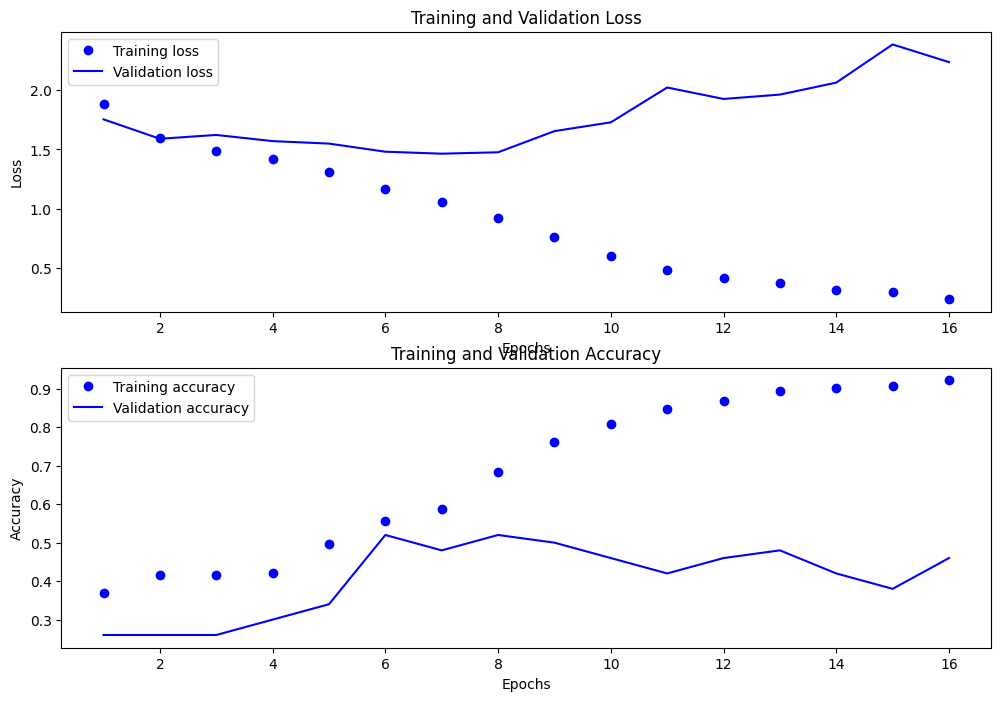

In [26]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from the previous training
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

plt.subplot(2, 1, 2)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

plt.show()


In [27]:
from keras.models import load_model


In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming 'df' is your DataFrame with 'Summary', 'News_Topic', and 'Sentiment' columns
# Extract the 'summary', 'news_topic', and 'sentiment' columns
summaries = df['Summary'].astype(str)
news_topics = df['News topic']
sentiments = df['Summary_Emotion']

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summaries)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index

In [30]:
# Iterate over each unique news topic
for topic in df['News topic'].unique():
    # Filter the DataFrame for the current topic
    topic_df = df[df['News topic'] == topic]

    # Extract 'summary' and 'sentiment' columns for the current topic
    topic_summaries = topic_df['Summary'].astype(str)
    topic_sentiments = topic_df['Summary_Emotion']

    # Tokenize the text
    sequences = tokenizer.texts_to_sequences(topic_summaries)
    padded_sequences = pad_sequences(sequences, maxlen=max_news_length)

    # Get the number of unique emotions for the current topic
    num_classes = len(topic_sentiments.unique())

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(topic_sentiments)
    y_one_hot = to_categorical(encoded_labels, num_classes=num_classes)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, y_one_hot, test_size=0.1, random_state=42
    )

In [31]:
save_directory = '/content/drive/MyDrive/Diss/many to one lstm/separated h5/'

# Assuming you have loaded a trained model
topic = "2023 US debt ceiling crisis"  # Replace with the specific topic you're interested in
loaded_model = load_model(f"{save_directory}lstm_model_2023 US debt ceiling crisis.h5")

# Evaluate on the test set
evaluation = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy for {topic}: {evaluation[1]}")


2/2 [==============================] - 1s 27ms/step - loss: 3.3151 - accuracy: 0.2400
Test Accuracy for 2023 US debt ceiling crisis: 0.23999999463558197


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have loaded a trained model
topic = "2023 US debt ceiling crisis"  # Replace with the specific topic you're interested in
loaded_model = load_model(f"{save_directory}lstm_model_2023 US debt ceiling crisis.h5")

# Assuming you have test data (X_test) and corresponding labels (y_test)
# Replace this with your actual test set
# Make sure your test set is preprocessed in the same way as your training data


# Make predictions on the test set
predictions = loaded_model.predict(X_test)

# If you're working with a classification problem and want to get class labels:
class_predictions = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), class_predictions))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), class_predictions)
print(conf_matrix)


2/2 [==============================] - 1s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        13
           1       0.00      0.00      0.00         3
           2       0.38      0.47      0.42        19
           3       0.00      0.00      0.00         1
           4       0.05      0.12      0.07         8
           5       0.00      0.00      0.00         6

    accuracy                           0.24        50
   macro avg       0.13      0.13      0.12        50
weighted avg       0.24      0.24      0.23        50

Confusion Matrix:
[[ 2  0  6  0  5  0]
 [ 0  0  1  0  2  0]
 [ 0  0  9  0 10  0]
 [ 0  0  0  0  1  0]
 [ 3  0  4  0  1  0]
 [ 1  0  4  0  1  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
